In [1]:
#!pip install tensorflow==2.2
#!pip uninstall tensorflow_text

In [2]:
# ------------------------ # 
import sys
sys.path.insert(1, '../')
# ------------------------ # 

import os

import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt

from VQGAN.models import *
from VQGAN.utils import *
from VQGAN.data import *

# Data

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


def create_data_set(data_directory, batch_size=12):
    """
    Creates a data set using the files in the data directory. If
    file_names is specified, only these file names will be used
    in the data set.
    :param data_directory: the path to the data directory.
    :param file_names: a list of full path file names
    :param img_dim: the size of the image
    :param batch_size: the batch size. Can be updated as ds = ds.batch(new_batch_size)
    :return: data set (ds)
    :return: n
    """
    
    files = os.listdir(data_directory)
    n = len(files)
    
    #file_names = [f"{x:04d}" for x in range(n)]
    file_names = [os.path.join(data_directory, f) for f in files] 
    

    def parse_image(filename):
        """
        Reads the image and returns the image, noise and constant tensors
        :param filename: the image to load
        :return: style batch - ( image, noise_img, constant)
        """
        #number = filename.numpy().decode()
        #filename_ze = os.path.join(data_directory, number + ".npy")
        filename_ze = filename.numpy().decode()
        ze = np.load(filename_ze)[0]
        
        return ze, ze
    
    lambda_parse = lambda item: tuple(tf.py_function(parse_image, [item], [tf.float32, tf.float32]))

    n = len(file_names)
    ds = tf.data.Dataset.from_tensor_slices(file_names)
    ds = ds.shuffle(buffer_size=n, seed=1234, reshuffle_each_iteration=False)
    
    ds = ds.map(lambda_parse,
                num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.repeat()  # loop forever
    return ds, n

In [4]:
DATA_DIR = "/home/simon/Desktop/Project3/representations/train_features"
VAL_DIR = "/home/simon/Desktop/Project3/representations/validation_features"
BATCH_SIZE = 1024
EPOCHS=20
Z_DIM = 512

In [5]:
datagen, N = create_data_set(data_directory=DATA_DIR,
                              batch_size=BATCH_SIZE)

In [6]:
val_gen, VN = create_data_set(data_directory=VAL_DIR,
                              batch_size=BATCH_SIZE)

In [7]:
for x,y in datagen:
    break

In [8]:
x.shape

TensorShape([1024, 16, 16, 256])

# Models

## Encoder

In [9]:
encoder_in = tf.keras.layers.Input((16, 16, 256))
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same")(encoder_in)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding="same")(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(Z_DIM)(x)
encoder_out = tf.keras.layers.LeakyReLU(0.2)(x)
encoder = tf.keras.Model(inputs=[encoder_in], outputs=[encoder_out], name="encoder")

In [10]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 16, 256)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         1180160   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 1024)        4719616   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               8389

## Decoder

In [11]:
decoder_in = tf.keras.layers.Input((Z_DIM,))
x = tf.keras.layers.Dense(4*4*1024)(decoder_in)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Reshape((4, 4, 1024))(x)
x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
decoder_out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(x)
decoder = tf.keras.Model(inputs=[decoder_in],
                         outputs=[decoder_out],
                         name="decoder")

In [12]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             8404992   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         4719104   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       1179

## Autoencoder

In [13]:
ae_in = encoder_in
ae_out = decoder(encoder(encoder_in))
ae = tf.keras.Model(inputs=[ae_in], outputs=[ae_out], name="autoencoder")

In [14]:
ae.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss="mse")

# Train

In [16]:
history = ae.fit(
                 datagen,
                 steps_per_epoch=N // BATCH_SIZE,
                 epochs=300,
                 validation_data=val_gen,
                 validation_steps=VN // BATCH_SIZE
                )

Epoch 1/300
11/11 [==============================] - 7s 641ms/step - loss: 0.0401 - val_loss: 0.0363
Epoch 2/300
11/11 [==============================] - 7s 595ms/step - loss: 0.0311 - val_loss: 0.0277
Epoch 3/300
11/11 [==============================] - 7s 596ms/step - loss: 0.0229 - val_loss: 0.0223
Epoch 4/300
11/11 [==============================] - 7s 597ms/step - loss: 0.0193 - val_loss: 0.0206
Epoch 5/300
11/11 [==============================] - 7s 597ms/step - loss: 0.0181 - val_loss: 0.0200
Epoch 6/300
11/11 [==============================] - 7s 600ms/step - loss: 0.0176 - val_loss: 0.0196
Epoch 7/300
11/11 [==============================] - 7s 599ms/step - loss: 0.0173 - val_loss: 0.0195
Epoch 8/300
11/11 [==============================] - 7s 606ms/step - loss: 0.0172 - val_loss: 0.0194
Epoch 9/300
11/11 [==============================] - 7s 606ms/step - loss: 0.0171 - val_loss: 0.0193
Epoch 10/300
11/11 [==============================] - 7s 613ms/step - loss: 0.0170 - val_lo

KeyboardInterrupt: 

In [23]:
# beat 0.0194 val loss

In [17]:
history = ae.history.history

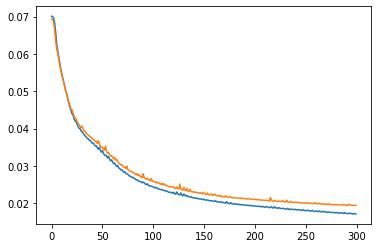

In [18]:
for key in history:
    plt.plot(range(len(history[key])), history[key], label=key)
plt.show()

In [15]:
#ae.save_weights("/home/simon/Desktop/Project3/weights/2021-09-15_ae_300_epochs.h5")
ae.load_weights("/home/simon/Desktop/Project3/weights/2021-09-15_ae_300_epochs.h5")

In [15]:
for x in val_gen:
    break

In [16]:
w = encoder(x)
x_recon = decoder(w)

In [17]:
np.save("/home/simon/Desktop/Project3/representations/ae_validation_recons/ae_recon.npy", x_recon.numpy())

In [18]:
np.save("/home/simon/Desktop/Project3/representations/ae_validation_recons/ae_real.npy", x[0].numpy())

# Get Latent Representations

In [16]:
LATENT_DIR = "/home/simon/Desktop/Project3/representations/train_latents"

In [17]:
files = os.listdir(DATA_DIR)

In [18]:
files = np.array(files)

In [21]:
for i, file in enumerate(files):
    
    print(i+1, "of", len(files))
    
    fname = os.path.join(DATA_DIR, file)
    
    z_e = np.load(fname)
    
    latent = encoder.predict(z_e)
    
    out_name = os.path.join(LATENT_DIR, file)
    
    np.save(out_name, latent)
    
    #break

1 of 11588
2 of 11588
3 of 11588
4 of 11588
5 of 11588
6 of 11588
7 of 11588
8 of 11588
9 of 11588
10 of 11588
11 of 11588
12 of 11588
13 of 11588
14 of 11588
15 of 11588
16 of 11588
17 of 11588
18 of 11588
19 of 11588
20 of 11588
21 of 11588
22 of 11588
23 of 11588
24 of 11588
25 of 11588
26 of 11588
27 of 11588
28 of 11588
29 of 11588
30 of 11588
31 of 11588
32 of 11588
33 of 11588
34 of 11588
35 of 11588
36 of 11588
37 of 11588
38 of 11588
39 of 11588
40 of 11588
41 of 11588
42 of 11588
43 of 11588
44 of 11588
45 of 11588
46 of 11588
47 of 11588
48 of 11588
49 of 11588
50 of 11588
51 of 11588
52 of 11588
53 of 11588
54 of 11588
55 of 11588
56 of 11588
57 of 11588
58 of 11588
59 of 11588
60 of 11588
61 of 11588
62 of 11588
63 of 11588
64 of 11588
65 of 11588
66 of 11588
67 of 11588
68 of 11588
69 of 11588
70 of 11588
71 of 11588
72 of 11588
73 of 11588
74 of 11588
75 of 11588
76 of 11588
77 of 11588
78 of 11588
79 of 11588
80 of 11588
81 of 11588
82 of 11588
83 of 11588
84 of 11588
8

649 of 11588
650 of 11588
651 of 11588
652 of 11588
653 of 11588
654 of 11588
655 of 11588
656 of 11588
657 of 11588
658 of 11588
659 of 11588
660 of 11588
661 of 11588
662 of 11588
663 of 11588
664 of 11588
665 of 11588
666 of 11588
667 of 11588
668 of 11588
669 of 11588
670 of 11588
671 of 11588
672 of 11588
673 of 11588
674 of 11588
675 of 11588
676 of 11588
677 of 11588
678 of 11588
679 of 11588
680 of 11588
681 of 11588
682 of 11588
683 of 11588
684 of 11588
685 of 11588
686 of 11588
687 of 11588
688 of 11588
689 of 11588
690 of 11588
691 of 11588
692 of 11588
693 of 11588
694 of 11588
695 of 11588
696 of 11588
697 of 11588
698 of 11588
699 of 11588
700 of 11588
701 of 11588
702 of 11588
703 of 11588
704 of 11588
705 of 11588
706 of 11588
707 of 11588
708 of 11588
709 of 11588
710 of 11588
711 of 11588
712 of 11588
713 of 11588
714 of 11588
715 of 11588
716 of 11588
717 of 11588
718 of 11588
719 of 11588
720 of 11588
721 of 11588
722 of 11588
723 of 11588
724 of 11588
725 of 11588

1260 of 11588
1261 of 11588
1262 of 11588
1263 of 11588
1264 of 11588
1265 of 11588
1266 of 11588
1267 of 11588
1268 of 11588
1269 of 11588
1270 of 11588
1271 of 11588
1272 of 11588
1273 of 11588
1274 of 11588
1275 of 11588
1276 of 11588
1277 of 11588
1278 of 11588
1279 of 11588
1280 of 11588
1281 of 11588
1282 of 11588
1283 of 11588
1284 of 11588
1285 of 11588
1286 of 11588
1287 of 11588
1288 of 11588
1289 of 11588
1290 of 11588
1291 of 11588
1292 of 11588
1293 of 11588
1294 of 11588
1295 of 11588
1296 of 11588
1297 of 11588
1298 of 11588
1299 of 11588
1300 of 11588
1301 of 11588
1302 of 11588
1303 of 11588
1304 of 11588
1305 of 11588
1306 of 11588
1307 of 11588
1308 of 11588
1309 of 11588
1310 of 11588
1311 of 11588
1312 of 11588
1313 of 11588
1314 of 11588
1315 of 11588
1316 of 11588
1317 of 11588
1318 of 11588
1319 of 11588
1320 of 11588
1321 of 11588
1322 of 11588
1323 of 11588
1324 of 11588
1325 of 11588
1326 of 11588
1327 of 11588
1328 of 11588
1329 of 11588
1330 of 11588
1331 o

1852 of 11588
1853 of 11588
1854 of 11588
1855 of 11588
1856 of 11588
1857 of 11588
1858 of 11588
1859 of 11588
1860 of 11588
1861 of 11588
1862 of 11588
1863 of 11588
1864 of 11588
1865 of 11588
1866 of 11588
1867 of 11588
1868 of 11588
1869 of 11588
1870 of 11588
1871 of 11588
1872 of 11588
1873 of 11588
1874 of 11588
1875 of 11588
1876 of 11588
1877 of 11588
1878 of 11588
1879 of 11588
1880 of 11588
1881 of 11588
1882 of 11588
1883 of 11588
1884 of 11588
1885 of 11588
1886 of 11588
1887 of 11588
1888 of 11588
1889 of 11588
1890 of 11588
1891 of 11588
1892 of 11588
1893 of 11588
1894 of 11588
1895 of 11588
1896 of 11588
1897 of 11588
1898 of 11588
1899 of 11588
1900 of 11588
1901 of 11588
1902 of 11588
1903 of 11588
1904 of 11588
1905 of 11588
1906 of 11588
1907 of 11588
1908 of 11588
1909 of 11588
1910 of 11588
1911 of 11588
1912 of 11588
1913 of 11588
1914 of 11588
1915 of 11588
1916 of 11588
1917 of 11588
1918 of 11588
1919 of 11588
1920 of 11588
1921 of 11588
1922 of 11588
1923 o

2449 of 11588
2450 of 11588
2451 of 11588
2452 of 11588
2453 of 11588
2454 of 11588
2455 of 11588
2456 of 11588
2457 of 11588
2458 of 11588
2459 of 11588
2460 of 11588
2461 of 11588
2462 of 11588
2463 of 11588
2464 of 11588
2465 of 11588
2466 of 11588
2467 of 11588
2468 of 11588
2469 of 11588
2470 of 11588
2471 of 11588
2472 of 11588
2473 of 11588
2474 of 11588
2475 of 11588
2476 of 11588
2477 of 11588
2478 of 11588
2479 of 11588
2480 of 11588
2481 of 11588
2482 of 11588
2483 of 11588
2484 of 11588
2485 of 11588
2486 of 11588
2487 of 11588
2488 of 11588
2489 of 11588
2490 of 11588
2491 of 11588
2492 of 11588
2493 of 11588
2494 of 11588
2495 of 11588
2496 of 11588
2497 of 11588
2498 of 11588
2499 of 11588
2500 of 11588
2501 of 11588
2502 of 11588
2503 of 11588
2504 of 11588
2505 of 11588
2506 of 11588
2507 of 11588
2508 of 11588
2509 of 11588
2510 of 11588
2511 of 11588
2512 of 11588
2513 of 11588
2514 of 11588
2515 of 11588
2516 of 11588
2517 of 11588
2518 of 11588
2519 of 11588
2520 o

3036 of 11588
3037 of 11588
3038 of 11588
3039 of 11588
3040 of 11588
3041 of 11588
3042 of 11588
3043 of 11588
3044 of 11588
3045 of 11588
3046 of 11588
3047 of 11588
3048 of 11588
3049 of 11588
3050 of 11588
3051 of 11588
3052 of 11588
3053 of 11588
3054 of 11588
3055 of 11588
3056 of 11588
3057 of 11588
3058 of 11588
3059 of 11588
3060 of 11588
3061 of 11588
3062 of 11588
3063 of 11588
3064 of 11588
3065 of 11588
3066 of 11588
3067 of 11588
3068 of 11588
3069 of 11588
3070 of 11588
3071 of 11588
3072 of 11588
3073 of 11588
3074 of 11588
3075 of 11588
3076 of 11588
3077 of 11588
3078 of 11588
3079 of 11588
3080 of 11588
3081 of 11588
3082 of 11588
3083 of 11588
3084 of 11588
3085 of 11588
3086 of 11588
3087 of 11588
3088 of 11588
3089 of 11588
3090 of 11588
3091 of 11588
3092 of 11588
3093 of 11588
3094 of 11588
3095 of 11588
3096 of 11588
3097 of 11588
3098 of 11588
3099 of 11588
3100 of 11588
3101 of 11588
3102 of 11588
3103 of 11588
3104 of 11588
3105 of 11588
3106 of 11588
3107 o

3626 of 11588
3627 of 11588
3628 of 11588
3629 of 11588
3630 of 11588
3631 of 11588
3632 of 11588
3633 of 11588
3634 of 11588
3635 of 11588
3636 of 11588
3637 of 11588
3638 of 11588
3639 of 11588
3640 of 11588
3641 of 11588
3642 of 11588
3643 of 11588
3644 of 11588
3645 of 11588
3646 of 11588
3647 of 11588
3648 of 11588
3649 of 11588
3650 of 11588
3651 of 11588
3652 of 11588
3653 of 11588
3654 of 11588
3655 of 11588
3656 of 11588
3657 of 11588
3658 of 11588
3659 of 11588
3660 of 11588
3661 of 11588
3662 of 11588
3663 of 11588
3664 of 11588
3665 of 11588
3666 of 11588
3667 of 11588
3668 of 11588
3669 of 11588
3670 of 11588
3671 of 11588
3672 of 11588
3673 of 11588
3674 of 11588
3675 of 11588
3676 of 11588
3677 of 11588
3678 of 11588
3679 of 11588
3680 of 11588
3681 of 11588
3682 of 11588
3683 of 11588
3684 of 11588
3685 of 11588
3686 of 11588
3687 of 11588
3688 of 11588
3689 of 11588
3690 of 11588
3691 of 11588
3692 of 11588
3693 of 11588
3694 of 11588
3695 of 11588
3696 of 11588
3697 o

4215 of 11588
4216 of 11588
4217 of 11588
4218 of 11588
4219 of 11588
4220 of 11588
4221 of 11588
4222 of 11588
4223 of 11588
4224 of 11588
4225 of 11588
4226 of 11588
4227 of 11588
4228 of 11588
4229 of 11588
4230 of 11588
4231 of 11588
4232 of 11588
4233 of 11588
4234 of 11588
4235 of 11588
4236 of 11588
4237 of 11588
4238 of 11588
4239 of 11588
4240 of 11588
4241 of 11588
4242 of 11588
4243 of 11588
4244 of 11588
4245 of 11588
4246 of 11588
4247 of 11588
4248 of 11588
4249 of 11588
4250 of 11588
4251 of 11588
4252 of 11588
4253 of 11588
4254 of 11588
4255 of 11588
4256 of 11588
4257 of 11588
4258 of 11588
4259 of 11588
4260 of 11588
4261 of 11588
4262 of 11588
4263 of 11588
4264 of 11588
4265 of 11588
4266 of 11588
4267 of 11588
4268 of 11588
4269 of 11588
4270 of 11588
4271 of 11588
4272 of 11588
4273 of 11588
4274 of 11588
4275 of 11588
4276 of 11588
4277 of 11588
4278 of 11588
4279 of 11588
4280 of 11588
4281 of 11588
4282 of 11588
4283 of 11588
4284 of 11588
4285 of 11588
4286 o

4802 of 11588
4803 of 11588
4804 of 11588
4805 of 11588
4806 of 11588
4807 of 11588
4808 of 11588
4809 of 11588
4810 of 11588
4811 of 11588
4812 of 11588
4813 of 11588
4814 of 11588
4815 of 11588
4816 of 11588
4817 of 11588
4818 of 11588
4819 of 11588
4820 of 11588
4821 of 11588
4822 of 11588
4823 of 11588
4824 of 11588
4825 of 11588
4826 of 11588
4827 of 11588
4828 of 11588
4829 of 11588
4830 of 11588
4831 of 11588
4832 of 11588
4833 of 11588
4834 of 11588
4835 of 11588
4836 of 11588
4837 of 11588
4838 of 11588
4839 of 11588
4840 of 11588
4841 of 11588
4842 of 11588
4843 of 11588
4844 of 11588
4845 of 11588
4846 of 11588
4847 of 11588
4848 of 11588
4849 of 11588
4850 of 11588
4851 of 11588
4852 of 11588
4853 of 11588
4854 of 11588
4855 of 11588
4856 of 11588
4857 of 11588
4858 of 11588
4859 of 11588
4860 of 11588
4861 of 11588
4862 of 11588
4863 of 11588
4864 of 11588
4865 of 11588
4866 of 11588
4867 of 11588
4868 of 11588
4869 of 11588
4870 of 11588
4871 of 11588
4872 of 11588
4873 o

5392 of 11588
5393 of 11588
5394 of 11588
5395 of 11588
5396 of 11588
5397 of 11588
5398 of 11588
5399 of 11588
5400 of 11588
5401 of 11588
5402 of 11588
5403 of 11588
5404 of 11588
5405 of 11588
5406 of 11588
5407 of 11588
5408 of 11588
5409 of 11588
5410 of 11588
5411 of 11588
5412 of 11588
5413 of 11588
5414 of 11588
5415 of 11588
5416 of 11588
5417 of 11588
5418 of 11588
5419 of 11588
5420 of 11588
5421 of 11588
5422 of 11588
5423 of 11588
5424 of 11588
5425 of 11588
5426 of 11588
5427 of 11588
5428 of 11588
5429 of 11588
5430 of 11588
5431 of 11588
5432 of 11588
5433 of 11588
5434 of 11588
5435 of 11588
5436 of 11588
5437 of 11588
5438 of 11588
5439 of 11588
5440 of 11588
5441 of 11588
5442 of 11588
5443 of 11588
5444 of 11588
5445 of 11588
5446 of 11588
5447 of 11588
5448 of 11588
5449 of 11588
5450 of 11588
5451 of 11588
5452 of 11588
5453 of 11588
5454 of 11588
5455 of 11588
5456 of 11588
5457 of 11588
5458 of 11588
5459 of 11588
5460 of 11588
5461 of 11588
5462 of 11588
5463 o

5985 of 11588
5986 of 11588
5987 of 11588
5988 of 11588
5989 of 11588
5990 of 11588
5991 of 11588
5992 of 11588
5993 of 11588
5994 of 11588
5995 of 11588
5996 of 11588
5997 of 11588
5998 of 11588
5999 of 11588
6000 of 11588
6001 of 11588
6002 of 11588
6003 of 11588
6004 of 11588
6005 of 11588
6006 of 11588
6007 of 11588
6008 of 11588
6009 of 11588
6010 of 11588
6011 of 11588
6012 of 11588
6013 of 11588
6014 of 11588
6015 of 11588
6016 of 11588
6017 of 11588
6018 of 11588
6019 of 11588
6020 of 11588
6021 of 11588
6022 of 11588
6023 of 11588
6024 of 11588
6025 of 11588
6026 of 11588
6027 of 11588
6028 of 11588
6029 of 11588
6030 of 11588
6031 of 11588
6032 of 11588
6033 of 11588
6034 of 11588
6035 of 11588
6036 of 11588
6037 of 11588
6038 of 11588
6039 of 11588
6040 of 11588
6041 of 11588
6042 of 11588
6043 of 11588
6044 of 11588
6045 of 11588
6046 of 11588
6047 of 11588
6048 of 11588
6049 of 11588
6050 of 11588
6051 of 11588
6052 of 11588
6053 of 11588
6054 of 11588
6055 of 11588
6056 o

6574 of 11588
6575 of 11588
6576 of 11588
6577 of 11588
6578 of 11588
6579 of 11588
6580 of 11588
6581 of 11588
6582 of 11588
6583 of 11588
6584 of 11588
6585 of 11588
6586 of 11588
6587 of 11588
6588 of 11588
6589 of 11588
6590 of 11588
6591 of 11588
6592 of 11588
6593 of 11588
6594 of 11588
6595 of 11588
6596 of 11588
6597 of 11588
6598 of 11588
6599 of 11588
6600 of 11588
6601 of 11588
6602 of 11588
6603 of 11588
6604 of 11588
6605 of 11588
6606 of 11588
6607 of 11588
6608 of 11588
6609 of 11588
6610 of 11588
6611 of 11588
6612 of 11588
6613 of 11588
6614 of 11588
6615 of 11588
6616 of 11588
6617 of 11588
6618 of 11588
6619 of 11588
6620 of 11588
6621 of 11588
6622 of 11588
6623 of 11588
6624 of 11588
6625 of 11588
6626 of 11588
6627 of 11588
6628 of 11588
6629 of 11588
6630 of 11588
6631 of 11588
6632 of 11588
6633 of 11588
6634 of 11588
6635 of 11588
6636 of 11588
6637 of 11588
6638 of 11588
6639 of 11588
6640 of 11588
6641 of 11588
6642 of 11588
6643 of 11588
6644 of 11588
6645 o

7165 of 11588
7166 of 11588
7167 of 11588
7168 of 11588
7169 of 11588
7170 of 11588
7171 of 11588
7172 of 11588
7173 of 11588
7174 of 11588
7175 of 11588
7176 of 11588
7177 of 11588
7178 of 11588
7179 of 11588
7180 of 11588
7181 of 11588
7182 of 11588
7183 of 11588
7184 of 11588
7185 of 11588
7186 of 11588
7187 of 11588
7188 of 11588
7189 of 11588
7190 of 11588
7191 of 11588
7192 of 11588
7193 of 11588
7194 of 11588
7195 of 11588
7196 of 11588
7197 of 11588
7198 of 11588
7199 of 11588
7200 of 11588
7201 of 11588
7202 of 11588
7203 of 11588
7204 of 11588
7205 of 11588
7206 of 11588
7207 of 11588
7208 of 11588
7209 of 11588
7210 of 11588
7211 of 11588
7212 of 11588
7213 of 11588
7214 of 11588
7215 of 11588
7216 of 11588
7217 of 11588
7218 of 11588
7219 of 11588
7220 of 11588
7221 of 11588
7222 of 11588
7223 of 11588
7224 of 11588
7225 of 11588
7226 of 11588
7227 of 11588
7228 of 11588
7229 of 11588
7230 of 11588
7231 of 11588
7232 of 11588
7233 of 11588
7234 of 11588
7235 of 11588
7236 o

7758 of 11588
7759 of 11588
7760 of 11588
7761 of 11588
7762 of 11588
7763 of 11588
7764 of 11588
7765 of 11588
7766 of 11588
7767 of 11588
7768 of 11588
7769 of 11588
7770 of 11588
7771 of 11588
7772 of 11588
7773 of 11588
7774 of 11588
7775 of 11588
7776 of 11588
7777 of 11588
7778 of 11588
7779 of 11588
7780 of 11588
7781 of 11588
7782 of 11588
7783 of 11588
7784 of 11588
7785 of 11588
7786 of 11588
7787 of 11588
7788 of 11588
7789 of 11588
7790 of 11588
7791 of 11588
7792 of 11588
7793 of 11588
7794 of 11588
7795 of 11588
7796 of 11588
7797 of 11588
7798 of 11588
7799 of 11588
7800 of 11588
7801 of 11588
7802 of 11588
7803 of 11588
7804 of 11588
7805 of 11588
7806 of 11588
7807 of 11588
7808 of 11588
7809 of 11588
7810 of 11588
7811 of 11588
7812 of 11588
7813 of 11588
7814 of 11588
7815 of 11588
7816 of 11588
7817 of 11588
7818 of 11588
7819 of 11588
7820 of 11588
7821 of 11588
7822 of 11588
7823 of 11588
7824 of 11588
7825 of 11588
7826 of 11588
7827 of 11588
7828 of 11588
7829 o

8345 of 11588
8346 of 11588
8347 of 11588
8348 of 11588
8349 of 11588
8350 of 11588
8351 of 11588
8352 of 11588
8353 of 11588
8354 of 11588
8355 of 11588
8356 of 11588
8357 of 11588
8358 of 11588
8359 of 11588
8360 of 11588
8361 of 11588
8362 of 11588
8363 of 11588
8364 of 11588
8365 of 11588
8366 of 11588
8367 of 11588
8368 of 11588
8369 of 11588
8370 of 11588
8371 of 11588
8372 of 11588
8373 of 11588
8374 of 11588
8375 of 11588
8376 of 11588
8377 of 11588
8378 of 11588
8379 of 11588
8380 of 11588
8381 of 11588
8382 of 11588
8383 of 11588
8384 of 11588
8385 of 11588
8386 of 11588
8387 of 11588
8388 of 11588
8389 of 11588
8390 of 11588
8391 of 11588
8392 of 11588
8393 of 11588
8394 of 11588
8395 of 11588
8396 of 11588
8397 of 11588
8398 of 11588
8399 of 11588
8400 of 11588
8401 of 11588
8402 of 11588
8403 of 11588
8404 of 11588
8405 of 11588
8406 of 11588
8407 of 11588
8408 of 11588
8409 of 11588
8410 of 11588
8411 of 11588
8412 of 11588
8413 of 11588
8414 of 11588
8415 of 11588
8416 o

8939 of 11588
8940 of 11588
8941 of 11588
8942 of 11588
8943 of 11588
8944 of 11588
8945 of 11588
8946 of 11588
8947 of 11588
8948 of 11588
8949 of 11588
8950 of 11588
8951 of 11588
8952 of 11588
8953 of 11588
8954 of 11588
8955 of 11588
8956 of 11588
8957 of 11588
8958 of 11588
8959 of 11588
8960 of 11588
8961 of 11588
8962 of 11588
8963 of 11588
8964 of 11588
8965 of 11588
8966 of 11588
8967 of 11588
8968 of 11588
8969 of 11588
8970 of 11588
8971 of 11588
8972 of 11588
8973 of 11588
8974 of 11588
8975 of 11588
8976 of 11588
8977 of 11588
8978 of 11588
8979 of 11588
8980 of 11588
8981 of 11588
8982 of 11588
8983 of 11588
8984 of 11588
8985 of 11588
8986 of 11588
8987 of 11588
8988 of 11588
8989 of 11588
8990 of 11588
8991 of 11588
8992 of 11588
8993 of 11588
8994 of 11588
8995 of 11588
8996 of 11588
8997 of 11588
8998 of 11588
8999 of 11588
9000 of 11588
9001 of 11588
9002 of 11588
9003 of 11588
9004 of 11588
9005 of 11588
9006 of 11588
9007 of 11588
9008 of 11588
9009 of 11588
9010 o

9531 of 11588
9532 of 11588
9533 of 11588
9534 of 11588
9535 of 11588
9536 of 11588
9537 of 11588
9538 of 11588
9539 of 11588
9540 of 11588
9541 of 11588
9542 of 11588
9543 of 11588
9544 of 11588
9545 of 11588
9546 of 11588
9547 of 11588
9548 of 11588
9549 of 11588
9550 of 11588
9551 of 11588
9552 of 11588
9553 of 11588
9554 of 11588
9555 of 11588
9556 of 11588
9557 of 11588
9558 of 11588
9559 of 11588
9560 of 11588
9561 of 11588
9562 of 11588
9563 of 11588
9564 of 11588
9565 of 11588
9566 of 11588
9567 of 11588
9568 of 11588
9569 of 11588
9570 of 11588
9571 of 11588
9572 of 11588
9573 of 11588
9574 of 11588
9575 of 11588
9576 of 11588
9577 of 11588
9578 of 11588
9579 of 11588
9580 of 11588
9581 of 11588
9582 of 11588
9583 of 11588
9584 of 11588
9585 of 11588
9586 of 11588
9587 of 11588
9588 of 11588
9589 of 11588
9590 of 11588
9591 of 11588
9592 of 11588
9593 of 11588
9594 of 11588
9595 of 11588
9596 of 11588
9597 of 11588
9598 of 11588
9599 of 11588
9600 of 11588
9601 of 11588
9602 o

10110 of 11588
10111 of 11588
10112 of 11588
10113 of 11588
10114 of 11588
10115 of 11588
10116 of 11588
10117 of 11588
10118 of 11588
10119 of 11588
10120 of 11588
10121 of 11588
10122 of 11588
10123 of 11588
10124 of 11588
10125 of 11588
10126 of 11588
10127 of 11588
10128 of 11588
10129 of 11588
10130 of 11588
10131 of 11588
10132 of 11588
10133 of 11588
10134 of 11588
10135 of 11588
10136 of 11588
10137 of 11588
10138 of 11588
10139 of 11588
10140 of 11588
10141 of 11588
10142 of 11588
10143 of 11588
10144 of 11588
10145 of 11588
10146 of 11588
10147 of 11588
10148 of 11588
10149 of 11588
10150 of 11588
10151 of 11588
10152 of 11588
10153 of 11588
10154 of 11588
10155 of 11588
10156 of 11588
10157 of 11588
10158 of 11588
10159 of 11588
10160 of 11588
10161 of 11588
10162 of 11588
10163 of 11588
10164 of 11588
10165 of 11588
10166 of 11588
10167 of 11588
10168 of 11588
10169 of 11588
10170 of 11588
10171 of 11588
10172 of 11588
10173 of 11588
10174 of 11588
10175 of 11588
10176 of 1

10659 of 11588
10660 of 11588
10661 of 11588
10662 of 11588
10663 of 11588
10664 of 11588
10665 of 11588
10666 of 11588
10667 of 11588
10668 of 11588
10669 of 11588
10670 of 11588
10671 of 11588
10672 of 11588
10673 of 11588
10674 of 11588
10675 of 11588
10676 of 11588
10677 of 11588
10678 of 11588
10679 of 11588
10680 of 11588
10681 of 11588
10682 of 11588
10683 of 11588
10684 of 11588
10685 of 11588
10686 of 11588
10687 of 11588
10688 of 11588
10689 of 11588
10690 of 11588
10691 of 11588
10692 of 11588
10693 of 11588
10694 of 11588
10695 of 11588
10696 of 11588
10697 of 11588
10698 of 11588
10699 of 11588
10700 of 11588
10701 of 11588
10702 of 11588
10703 of 11588
10704 of 11588
10705 of 11588
10706 of 11588
10707 of 11588
10708 of 11588
10709 of 11588
10710 of 11588
10711 of 11588
10712 of 11588
10713 of 11588
10714 of 11588
10715 of 11588
10716 of 11588
10717 of 11588
10718 of 11588
10719 of 11588
10720 of 11588
10721 of 11588
10722 of 11588
10723 of 11588
10724 of 11588
10725 of 1

11216 of 11588
11217 of 11588
11218 of 11588
11219 of 11588
11220 of 11588
11221 of 11588
11222 of 11588
11223 of 11588
11224 of 11588
11225 of 11588
11226 of 11588
11227 of 11588
11228 of 11588
11229 of 11588
11230 of 11588
11231 of 11588
11232 of 11588
11233 of 11588
11234 of 11588
11235 of 11588
11236 of 11588
11237 of 11588
11238 of 11588
11239 of 11588
11240 of 11588
11241 of 11588
11242 of 11588
11243 of 11588
11244 of 11588
11245 of 11588
11246 of 11588
11247 of 11588
11248 of 11588
11249 of 11588
11250 of 11588
11251 of 11588
11252 of 11588
11253 of 11588
11254 of 11588
11255 of 11588
11256 of 11588
11257 of 11588
11258 of 11588
11259 of 11588
11260 of 11588
11261 of 11588
11262 of 11588
11263 of 11588
11264 of 11588
11265 of 11588
11266 of 11588
11267 of 11588
11268 of 11588
11269 of 11588
11270 of 11588
11271 of 11588
11272 of 11588
11273 of 11588
11274 of 11588
11275 of 11588
11276 of 11588
11277 of 11588
11278 of 11588
11279 of 11588
11280 of 11588
11281 of 11588
11282 of 1

In [22]:
z_e.shape

(1, 16, 16, 256)

In [23]:
latent.shape

(1, 512)

# Autoencoder Recons

In [19]:
OUT_DIR = "/home/simon/Desktop/Project3/FID/au_latents"

In [22]:
for i, file in enumerate(files):
    
    print(i+1, "of", len(files))
    
    fname = os.path.join(DATA_DIR, file)
    
    z_e = np.load(fname)
    
    latent = ae(z_e)
    
    out_name = os.path.join(OUT_DIR, file)
    
    np.save(out_name, latent)
    #
   # break

1 of 11588
2 of 11588
3 of 11588
4 of 11588
5 of 11588
6 of 11588
7 of 11588
8 of 11588
9 of 11588
10 of 11588
11 of 11588
12 of 11588
13 of 11588
14 of 11588
15 of 11588
16 of 11588
17 of 11588
18 of 11588
19 of 11588
20 of 11588
21 of 11588
22 of 11588
23 of 11588
24 of 11588
25 of 11588
26 of 11588
27 of 11588
28 of 11588
29 of 11588
30 of 11588
31 of 11588
32 of 11588
33 of 11588
34 of 11588
35 of 11588
36 of 11588
37 of 11588
38 of 11588
39 of 11588
40 of 11588
41 of 11588
42 of 11588
43 of 11588
44 of 11588
45 of 11588
46 of 11588
47 of 11588
48 of 11588
49 of 11588
50 of 11588
51 of 11588
52 of 11588
53 of 11588
54 of 11588
55 of 11588
56 of 11588
57 of 11588
58 of 11588
59 of 11588
60 of 11588
61 of 11588
62 of 11588
63 of 11588
64 of 11588
65 of 11588
66 of 11588
67 of 11588
68 of 11588
69 of 11588
70 of 11588
71 of 11588
72 of 11588
73 of 11588
74 of 11588
75 of 11588
76 of 11588
77 of 11588
78 of 11588
79 of 11588
80 of 11588
81 of 11588
82 of 11588
83 of 11588
84 of 11588
8

661 of 11588
662 of 11588
663 of 11588
664 of 11588
665 of 11588
666 of 11588
667 of 11588
668 of 11588
669 of 11588
670 of 11588
671 of 11588
672 of 11588
673 of 11588
674 of 11588
675 of 11588
676 of 11588
677 of 11588
678 of 11588
679 of 11588
680 of 11588
681 of 11588
682 of 11588
683 of 11588
684 of 11588
685 of 11588
686 of 11588
687 of 11588
688 of 11588
689 of 11588
690 of 11588
691 of 11588
692 of 11588
693 of 11588
694 of 11588
695 of 11588
696 of 11588
697 of 11588
698 of 11588
699 of 11588
700 of 11588
701 of 11588
702 of 11588
703 of 11588
704 of 11588
705 of 11588
706 of 11588
707 of 11588
708 of 11588
709 of 11588
710 of 11588
711 of 11588
712 of 11588
713 of 11588
714 of 11588
715 of 11588
716 of 11588
717 of 11588
718 of 11588
719 of 11588
720 of 11588
721 of 11588
722 of 11588
723 of 11588
724 of 11588
725 of 11588
726 of 11588
727 of 11588
728 of 11588
729 of 11588
730 of 11588
731 of 11588
732 of 11588
733 of 11588
734 of 11588
735 of 11588
736 of 11588
737 of 11588

1291 of 11588
1292 of 11588
1293 of 11588
1294 of 11588
1295 of 11588
1296 of 11588
1297 of 11588
1298 of 11588
1299 of 11588
1300 of 11588
1301 of 11588
1302 of 11588
1303 of 11588
1304 of 11588
1305 of 11588
1306 of 11588
1307 of 11588
1308 of 11588
1309 of 11588
1310 of 11588
1311 of 11588
1312 of 11588
1313 of 11588
1314 of 11588
1315 of 11588
1316 of 11588
1317 of 11588
1318 of 11588
1319 of 11588
1320 of 11588
1321 of 11588
1322 of 11588
1323 of 11588
1324 of 11588
1325 of 11588
1326 of 11588
1327 of 11588
1328 of 11588
1329 of 11588
1330 of 11588
1331 of 11588
1332 of 11588
1333 of 11588
1334 of 11588
1335 of 11588
1336 of 11588
1337 of 11588
1338 of 11588
1339 of 11588
1340 of 11588
1341 of 11588
1342 of 11588
1343 of 11588
1344 of 11588
1345 of 11588
1346 of 11588
1347 of 11588
1348 of 11588
1349 of 11588
1350 of 11588
1351 of 11588
1352 of 11588
1353 of 11588
1354 of 11588
1355 of 11588
1356 of 11588
1357 of 11588
1358 of 11588
1359 of 11588
1360 of 11588
1361 of 11588
1362 o

1890 of 11588
1891 of 11588
1892 of 11588
1893 of 11588
1894 of 11588
1895 of 11588
1896 of 11588
1897 of 11588
1898 of 11588
1899 of 11588
1900 of 11588
1901 of 11588
1902 of 11588
1903 of 11588
1904 of 11588
1905 of 11588
1906 of 11588
1907 of 11588
1908 of 11588
1909 of 11588
1910 of 11588
1911 of 11588
1912 of 11588
1913 of 11588
1914 of 11588
1915 of 11588
1916 of 11588
1917 of 11588
1918 of 11588
1919 of 11588
1920 of 11588
1921 of 11588
1922 of 11588
1923 of 11588
1924 of 11588
1925 of 11588
1926 of 11588
1927 of 11588
1928 of 11588
1929 of 11588
1930 of 11588
1931 of 11588
1932 of 11588
1933 of 11588
1934 of 11588
1935 of 11588
1936 of 11588
1937 of 11588
1938 of 11588
1939 of 11588
1940 of 11588
1941 of 11588
1942 of 11588
1943 of 11588
1944 of 11588
1945 of 11588
1946 of 11588
1947 of 11588
1948 of 11588
1949 of 11588
1950 of 11588
1951 of 11588
1952 of 11588
1953 of 11588
1954 of 11588
1955 of 11588
1956 of 11588
1957 of 11588
1958 of 11588
1959 of 11588
1960 of 11588
1961 o

2491 of 11588
2492 of 11588
2493 of 11588
2494 of 11588
2495 of 11588
2496 of 11588
2497 of 11588
2498 of 11588
2499 of 11588
2500 of 11588
2501 of 11588
2502 of 11588
2503 of 11588
2504 of 11588
2505 of 11588
2506 of 11588
2507 of 11588
2508 of 11588
2509 of 11588
2510 of 11588
2511 of 11588
2512 of 11588
2513 of 11588
2514 of 11588
2515 of 11588
2516 of 11588
2517 of 11588
2518 of 11588
2519 of 11588
2520 of 11588
2521 of 11588
2522 of 11588
2523 of 11588
2524 of 11588
2525 of 11588
2526 of 11588
2527 of 11588
2528 of 11588
2529 of 11588
2530 of 11588
2531 of 11588
2532 of 11588
2533 of 11588
2534 of 11588
2535 of 11588
2536 of 11588
2537 of 11588
2538 of 11588
2539 of 11588
2540 of 11588
2541 of 11588
2542 of 11588
2543 of 11588
2544 of 11588
2545 of 11588
2546 of 11588
2547 of 11588
2548 of 11588
2549 of 11588
2550 of 11588
2551 of 11588
2552 of 11588
2553 of 11588
2554 of 11588
2555 of 11588
2556 of 11588
2557 of 11588
2558 of 11588
2559 of 11588
2560 of 11588
2561 of 11588
2562 o

3086 of 11588
3087 of 11588
3088 of 11588
3089 of 11588
3090 of 11588
3091 of 11588
3092 of 11588
3093 of 11588
3094 of 11588
3095 of 11588
3096 of 11588
3097 of 11588
3098 of 11588
3099 of 11588
3100 of 11588
3101 of 11588
3102 of 11588
3103 of 11588
3104 of 11588
3105 of 11588
3106 of 11588
3107 of 11588
3108 of 11588
3109 of 11588
3110 of 11588
3111 of 11588
3112 of 11588
3113 of 11588
3114 of 11588
3115 of 11588
3116 of 11588
3117 of 11588
3118 of 11588
3119 of 11588
3120 of 11588
3121 of 11588
3122 of 11588
3123 of 11588
3124 of 11588
3125 of 11588
3126 of 11588
3127 of 11588
3128 of 11588
3129 of 11588
3130 of 11588
3131 of 11588
3132 of 11588
3133 of 11588
3134 of 11588
3135 of 11588
3136 of 11588
3137 of 11588
3138 of 11588
3139 of 11588
3140 of 11588
3141 of 11588
3142 of 11588
3143 of 11588
3144 of 11588
3145 of 11588
3146 of 11588
3147 of 11588
3148 of 11588
3149 of 11588
3150 of 11588
3151 of 11588
3152 of 11588
3153 of 11588
3154 of 11588
3155 of 11588
3156 of 11588
3157 o

3697 of 11588
3698 of 11588
3699 of 11588
3700 of 11588
3701 of 11588
3702 of 11588
3703 of 11588
3704 of 11588
3705 of 11588
3706 of 11588
3707 of 11588
3708 of 11588
3709 of 11588
3710 of 11588
3711 of 11588
3712 of 11588
3713 of 11588
3714 of 11588
3715 of 11588
3716 of 11588
3717 of 11588
3718 of 11588
3719 of 11588
3720 of 11588
3721 of 11588
3722 of 11588
3723 of 11588
3724 of 11588
3725 of 11588
3726 of 11588
3727 of 11588
3728 of 11588
3729 of 11588
3730 of 11588
3731 of 11588
3732 of 11588
3733 of 11588
3734 of 11588
3735 of 11588
3736 of 11588
3737 of 11588
3738 of 11588
3739 of 11588
3740 of 11588
3741 of 11588
3742 of 11588
3743 of 11588
3744 of 11588
3745 of 11588
3746 of 11588
3747 of 11588
3748 of 11588
3749 of 11588
3750 of 11588
3751 of 11588
3752 of 11588
3753 of 11588
3754 of 11588
3755 of 11588
3756 of 11588
3757 of 11588
3758 of 11588
3759 of 11588
3760 of 11588
3761 of 11588
3762 of 11588
3763 of 11588
3764 of 11588
3765 of 11588
3766 of 11588
3767 of 11588
3768 o

4310 of 11588
4311 of 11588
4312 of 11588
4313 of 11588
4314 of 11588
4315 of 11588
4316 of 11588
4317 of 11588
4318 of 11588
4319 of 11588
4320 of 11588
4321 of 11588
4322 of 11588
4323 of 11588
4324 of 11588
4325 of 11588
4326 of 11588
4327 of 11588
4328 of 11588
4329 of 11588
4330 of 11588
4331 of 11588
4332 of 11588
4333 of 11588
4334 of 11588
4335 of 11588
4336 of 11588
4337 of 11588
4338 of 11588
4339 of 11588
4340 of 11588
4341 of 11588
4342 of 11588
4343 of 11588
4344 of 11588
4345 of 11588
4346 of 11588
4347 of 11588
4348 of 11588
4349 of 11588
4350 of 11588
4351 of 11588
4352 of 11588
4353 of 11588
4354 of 11588
4355 of 11588
4356 of 11588
4357 of 11588
4358 of 11588
4359 of 11588
4360 of 11588
4361 of 11588
4362 of 11588
4363 of 11588
4364 of 11588
4365 of 11588
4366 of 11588
4367 of 11588
4368 of 11588
4369 of 11588
4370 of 11588
4371 of 11588
4372 of 11588
4373 of 11588
4374 of 11588
4375 of 11588
4376 of 11588
4377 of 11588
4378 of 11588
4379 of 11588
4380 of 11588
4381 o

4906 of 11588
4907 of 11588
4908 of 11588
4909 of 11588
4910 of 11588
4911 of 11588
4912 of 11588
4913 of 11588
4914 of 11588
4915 of 11588
4916 of 11588
4917 of 11588
4918 of 11588
4919 of 11588
4920 of 11588
4921 of 11588
4922 of 11588
4923 of 11588
4924 of 11588
4925 of 11588
4926 of 11588
4927 of 11588
4928 of 11588
4929 of 11588
4930 of 11588
4931 of 11588
4932 of 11588
4933 of 11588
4934 of 11588
4935 of 11588
4936 of 11588
4937 of 11588
4938 of 11588
4939 of 11588
4940 of 11588
4941 of 11588
4942 of 11588
4943 of 11588
4944 of 11588
4945 of 11588
4946 of 11588
4947 of 11588
4948 of 11588
4949 of 11588
4950 of 11588
4951 of 11588
4952 of 11588
4953 of 11588
4954 of 11588
4955 of 11588
4956 of 11588
4957 of 11588
4958 of 11588
4959 of 11588
4960 of 11588
4961 of 11588
4962 of 11588
4963 of 11588
4964 of 11588
4965 of 11588
4966 of 11588
4967 of 11588
4968 of 11588
4969 of 11588
4970 of 11588
4971 of 11588
4972 of 11588
4973 of 11588
4974 of 11588
4975 of 11588
4976 of 11588
4977 o

5493 of 11588
5494 of 11588
5495 of 11588
5496 of 11588
5497 of 11588
5498 of 11588
5499 of 11588
5500 of 11588
5501 of 11588
5502 of 11588
5503 of 11588
5504 of 11588
5505 of 11588
5506 of 11588
5507 of 11588
5508 of 11588
5509 of 11588
5510 of 11588
5511 of 11588
5512 of 11588
5513 of 11588
5514 of 11588
5515 of 11588
5516 of 11588
5517 of 11588
5518 of 11588
5519 of 11588
5520 of 11588
5521 of 11588
5522 of 11588
5523 of 11588
5524 of 11588
5525 of 11588
5526 of 11588
5527 of 11588
5528 of 11588
5529 of 11588
5530 of 11588
5531 of 11588
5532 of 11588
5533 of 11588
5534 of 11588
5535 of 11588
5536 of 11588
5537 of 11588
5538 of 11588
5539 of 11588
5540 of 11588
5541 of 11588
5542 of 11588
5543 of 11588
5544 of 11588
5545 of 11588
5546 of 11588
5547 of 11588
5548 of 11588
5549 of 11588
5550 of 11588
5551 of 11588
5552 of 11588
5553 of 11588
5554 of 11588
5555 of 11588
5556 of 11588
5557 of 11588
5558 of 11588
5559 of 11588
5560 of 11588
5561 of 11588
5562 of 11588
5563 of 11588
5564 o

6079 of 11588
6080 of 11588
6081 of 11588
6082 of 11588
6083 of 11588
6084 of 11588
6085 of 11588
6086 of 11588
6087 of 11588
6088 of 11588
6089 of 11588
6090 of 11588
6091 of 11588
6092 of 11588
6093 of 11588
6094 of 11588
6095 of 11588
6096 of 11588
6097 of 11588
6098 of 11588
6099 of 11588
6100 of 11588
6101 of 11588
6102 of 11588
6103 of 11588
6104 of 11588
6105 of 11588
6106 of 11588
6107 of 11588
6108 of 11588
6109 of 11588
6110 of 11588
6111 of 11588
6112 of 11588
6113 of 11588
6114 of 11588
6115 of 11588
6116 of 11588
6117 of 11588
6118 of 11588
6119 of 11588
6120 of 11588
6121 of 11588
6122 of 11588
6123 of 11588
6124 of 11588
6125 of 11588
6126 of 11588
6127 of 11588
6128 of 11588
6129 of 11588
6130 of 11588
6131 of 11588
6132 of 11588
6133 of 11588
6134 of 11588
6135 of 11588
6136 of 11588
6137 of 11588
6138 of 11588
6139 of 11588
6140 of 11588
6141 of 11588
6142 of 11588
6143 of 11588
6144 of 11588
6145 of 11588
6146 of 11588
6147 of 11588
6148 of 11588
6149 of 11588
6150 o

6686 of 11588
6687 of 11588
6688 of 11588
6689 of 11588
6690 of 11588
6691 of 11588
6692 of 11588
6693 of 11588
6694 of 11588
6695 of 11588
6696 of 11588
6697 of 11588
6698 of 11588
6699 of 11588
6700 of 11588
6701 of 11588
6702 of 11588
6703 of 11588
6704 of 11588
6705 of 11588
6706 of 11588
6707 of 11588
6708 of 11588
6709 of 11588
6710 of 11588
6711 of 11588
6712 of 11588
6713 of 11588
6714 of 11588
6715 of 11588
6716 of 11588
6717 of 11588
6718 of 11588
6719 of 11588
6720 of 11588
6721 of 11588
6722 of 11588
6723 of 11588
6724 of 11588
6725 of 11588
6726 of 11588
6727 of 11588
6728 of 11588
6729 of 11588
6730 of 11588
6731 of 11588
6732 of 11588
6733 of 11588
6734 of 11588
6735 of 11588
6736 of 11588
6737 of 11588
6738 of 11588
6739 of 11588
6740 of 11588
6741 of 11588
6742 of 11588
6743 of 11588
6744 of 11588
6745 of 11588
6746 of 11588
6747 of 11588
6748 of 11588
6749 of 11588
6750 of 11588
6751 of 11588
6752 of 11588
6753 of 11588
6754 of 11588
6755 of 11588
6756 of 11588
6757 o

7280 of 11588
7281 of 11588
7282 of 11588
7283 of 11588
7284 of 11588
7285 of 11588
7286 of 11588
7287 of 11588
7288 of 11588
7289 of 11588
7290 of 11588
7291 of 11588
7292 of 11588
7293 of 11588
7294 of 11588
7295 of 11588
7296 of 11588
7297 of 11588
7298 of 11588
7299 of 11588
7300 of 11588
7301 of 11588
7302 of 11588
7303 of 11588
7304 of 11588
7305 of 11588
7306 of 11588
7307 of 11588
7308 of 11588
7309 of 11588
7310 of 11588
7311 of 11588
7312 of 11588
7313 of 11588
7314 of 11588
7315 of 11588
7316 of 11588
7317 of 11588
7318 of 11588
7319 of 11588
7320 of 11588
7321 of 11588
7322 of 11588
7323 of 11588
7324 of 11588
7325 of 11588
7326 of 11588
7327 of 11588
7328 of 11588
7329 of 11588
7330 of 11588
7331 of 11588
7332 of 11588
7333 of 11588
7334 of 11588
7335 of 11588
7336 of 11588
7337 of 11588
7338 of 11588
7339 of 11588
7340 of 11588
7341 of 11588
7342 of 11588
7343 of 11588
7344 of 11588
7345 of 11588
7346 of 11588
7347 of 11588
7348 of 11588
7349 of 11588
7350 of 11588
7351 o

7899 of 11588
7900 of 11588
7901 of 11588
7902 of 11588
7903 of 11588
7904 of 11588
7905 of 11588
7906 of 11588
7907 of 11588
7908 of 11588
7909 of 11588
7910 of 11588
7911 of 11588
7912 of 11588
7913 of 11588
7914 of 11588
7915 of 11588
7916 of 11588
7917 of 11588
7918 of 11588
7919 of 11588
7920 of 11588
7921 of 11588
7922 of 11588
7923 of 11588
7924 of 11588
7925 of 11588
7926 of 11588
7927 of 11588
7928 of 11588
7929 of 11588
7930 of 11588
7931 of 11588
7932 of 11588
7933 of 11588
7934 of 11588
7935 of 11588
7936 of 11588
7937 of 11588
7938 of 11588
7939 of 11588
7940 of 11588
7941 of 11588
7942 of 11588
7943 of 11588
7944 of 11588
7945 of 11588
7946 of 11588
7947 of 11588
7948 of 11588
7949 of 11588
7950 of 11588
7951 of 11588
7952 of 11588
7953 of 11588
7954 of 11588
7955 of 11588
7956 of 11588
7957 of 11588
7958 of 11588
7959 of 11588
7960 of 11588
7961 of 11588
7962 of 11588
7963 of 11588
7964 of 11588
7965 of 11588
7966 of 11588
7967 of 11588
7968 of 11588
7969 of 11588
7970 o

8490 of 11588
8491 of 11588
8492 of 11588
8493 of 11588
8494 of 11588
8495 of 11588
8496 of 11588
8497 of 11588
8498 of 11588
8499 of 11588
8500 of 11588
8501 of 11588
8502 of 11588
8503 of 11588
8504 of 11588
8505 of 11588
8506 of 11588
8507 of 11588
8508 of 11588
8509 of 11588
8510 of 11588
8511 of 11588
8512 of 11588
8513 of 11588
8514 of 11588
8515 of 11588
8516 of 11588
8517 of 11588
8518 of 11588
8519 of 11588
8520 of 11588
8521 of 11588
8522 of 11588
8523 of 11588
8524 of 11588
8525 of 11588
8526 of 11588
8527 of 11588
8528 of 11588
8529 of 11588
8530 of 11588
8531 of 11588
8532 of 11588
8533 of 11588
8534 of 11588
8535 of 11588
8536 of 11588
8537 of 11588
8538 of 11588
8539 of 11588
8540 of 11588
8541 of 11588
8542 of 11588
8543 of 11588
8544 of 11588
8545 of 11588
8546 of 11588
8547 of 11588
8548 of 11588
8549 of 11588
8550 of 11588
8551 of 11588
8552 of 11588
8553 of 11588
8554 of 11588
8555 of 11588
8556 of 11588
8557 of 11588
8558 of 11588
8559 of 11588
8560 of 11588
8561 o

9104 of 11588
9105 of 11588
9106 of 11588
9107 of 11588
9108 of 11588
9109 of 11588
9110 of 11588
9111 of 11588
9112 of 11588
9113 of 11588
9114 of 11588
9115 of 11588
9116 of 11588
9117 of 11588
9118 of 11588
9119 of 11588
9120 of 11588
9121 of 11588
9122 of 11588
9123 of 11588
9124 of 11588
9125 of 11588
9126 of 11588
9127 of 11588
9128 of 11588
9129 of 11588
9130 of 11588
9131 of 11588
9132 of 11588
9133 of 11588
9134 of 11588
9135 of 11588
9136 of 11588
9137 of 11588
9138 of 11588
9139 of 11588
9140 of 11588
9141 of 11588
9142 of 11588
9143 of 11588
9144 of 11588
9145 of 11588
9146 of 11588
9147 of 11588
9148 of 11588
9149 of 11588
9150 of 11588
9151 of 11588
9152 of 11588
9153 of 11588
9154 of 11588
9155 of 11588
9156 of 11588
9157 of 11588
9158 of 11588
9159 of 11588
9160 of 11588
9161 of 11588
9162 of 11588
9163 of 11588
9164 of 11588
9165 of 11588
9166 of 11588
9167 of 11588
9168 of 11588
9169 of 11588
9170 of 11588
9171 of 11588
9172 of 11588
9173 of 11588
9174 of 11588
9175 o

9692 of 11588
9693 of 11588
9694 of 11588
9695 of 11588
9696 of 11588
9697 of 11588
9698 of 11588
9699 of 11588
9700 of 11588
9701 of 11588
9702 of 11588
9703 of 11588
9704 of 11588
9705 of 11588
9706 of 11588
9707 of 11588
9708 of 11588
9709 of 11588
9710 of 11588
9711 of 11588
9712 of 11588
9713 of 11588
9714 of 11588
9715 of 11588
9716 of 11588
9717 of 11588
9718 of 11588
9719 of 11588
9720 of 11588
9721 of 11588
9722 of 11588
9723 of 11588
9724 of 11588
9725 of 11588
9726 of 11588
9727 of 11588
9728 of 11588
9729 of 11588
9730 of 11588
9731 of 11588
9732 of 11588
9733 of 11588
9734 of 11588
9735 of 11588
9736 of 11588
9737 of 11588
9738 of 11588
9739 of 11588
9740 of 11588
9741 of 11588
9742 of 11588
9743 of 11588
9744 of 11588
9745 of 11588
9746 of 11588
9747 of 11588
9748 of 11588
9749 of 11588
9750 of 11588
9751 of 11588
9752 of 11588
9753 of 11588
9754 of 11588
9755 of 11588
9756 of 11588
9757 of 11588
9758 of 11588
9759 of 11588
9760 of 11588
9761 of 11588
9762 of 11588
9763 o

10278 of 11588
10279 of 11588
10280 of 11588
10281 of 11588
10282 of 11588
10283 of 11588
10284 of 11588
10285 of 11588
10286 of 11588
10287 of 11588
10288 of 11588
10289 of 11588
10290 of 11588
10291 of 11588
10292 of 11588
10293 of 11588
10294 of 11588
10295 of 11588
10296 of 11588
10297 of 11588
10298 of 11588
10299 of 11588
10300 of 11588
10301 of 11588
10302 of 11588
10303 of 11588
10304 of 11588
10305 of 11588
10306 of 11588
10307 of 11588
10308 of 11588
10309 of 11588
10310 of 11588
10311 of 11588
10312 of 11588
10313 of 11588
10314 of 11588
10315 of 11588
10316 of 11588
10317 of 11588
10318 of 11588
10319 of 11588
10320 of 11588
10321 of 11588
10322 of 11588
10323 of 11588
10324 of 11588
10325 of 11588
10326 of 11588
10327 of 11588
10328 of 11588
10329 of 11588
10330 of 11588
10331 of 11588
10332 of 11588
10333 of 11588
10334 of 11588
10335 of 11588
10336 of 11588
10337 of 11588
10338 of 11588
10339 of 11588
10340 of 11588
10341 of 11588
10342 of 11588
10343 of 11588
10344 of 1

10830 of 11588
10831 of 11588
10832 of 11588
10833 of 11588
10834 of 11588
10835 of 11588
10836 of 11588
10837 of 11588
10838 of 11588
10839 of 11588
10840 of 11588
10841 of 11588
10842 of 11588
10843 of 11588
10844 of 11588
10845 of 11588
10846 of 11588
10847 of 11588
10848 of 11588
10849 of 11588
10850 of 11588
10851 of 11588
10852 of 11588
10853 of 11588
10854 of 11588
10855 of 11588
10856 of 11588
10857 of 11588
10858 of 11588
10859 of 11588
10860 of 11588
10861 of 11588
10862 of 11588
10863 of 11588
10864 of 11588
10865 of 11588
10866 of 11588
10867 of 11588
10868 of 11588
10869 of 11588
10870 of 11588
10871 of 11588
10872 of 11588
10873 of 11588
10874 of 11588
10875 of 11588
10876 of 11588
10877 of 11588
10878 of 11588
10879 of 11588
10880 of 11588
10881 of 11588
10882 of 11588
10883 of 11588
10884 of 11588
10885 of 11588
10886 of 11588
10887 of 11588
10888 of 11588
10889 of 11588
10890 of 11588
10891 of 11588
10892 of 11588
10893 of 11588
10894 of 11588
10895 of 11588
10896 of 1

11401 of 11588
11402 of 11588
11403 of 11588
11404 of 11588
11405 of 11588
11406 of 11588
11407 of 11588
11408 of 11588
11409 of 11588
11410 of 11588
11411 of 11588
11412 of 11588
11413 of 11588
11414 of 11588
11415 of 11588
11416 of 11588
11417 of 11588
11418 of 11588
11419 of 11588
11420 of 11588
11421 of 11588
11422 of 11588
11423 of 11588
11424 of 11588
11425 of 11588
11426 of 11588
11427 of 11588
11428 of 11588
11429 of 11588
11430 of 11588
11431 of 11588
11432 of 11588
11433 of 11588
11434 of 11588
11435 of 11588
11436 of 11588
11437 of 11588
11438 of 11588
11439 of 11588
11440 of 11588
11441 of 11588
11442 of 11588
11443 of 11588
11444 of 11588
11445 of 11588
11446 of 11588
11447 of 11588
11448 of 11588
11449 of 11588
11450 of 11588
11451 of 11588
11452 of 11588
11453 of 11588
11454 of 11588
11455 of 11588
11456 of 11588
11457 of 11588
11458 of 11588
11459 of 11588
11460 of 11588
11461 of 11588
11462 of 11588
11463 of 11588
11464 of 11588
11465 of 11588
11466 of 11588
11467 of 1

# Dimensionality Reduction

In [94]:
import umap

In [25]:
latents = []
for i, file in enumerate(files):
    
    print(i+1, "of", len(files), end="\r")
    
    fname = os.path.join(LATENT_DIR, file)
    
    latents.append(np.load(fname))
    
    #break

In [28]:
latents.shape

(11588, 512)

In [27]:
latents = np.vstack(latents)

In [95]:
#np.save("/home/simon/Desktop/Project3/representations/train_latents.npy", latents)
#np.save("/home/simon/Desktop/Project3/representations/train_files.npy", files)
latents = np.load("/home/simon/Desktop/Project3/representations/train_latents.npy")
files = np.load("/home/simon/Desktop/Project3/representations/train_files.npy")

In [96]:
reducer = umap.UMAP()

In [97]:
embedding = reducer.fit_transform(latents)

In [98]:
embedding.shape

(11588, 2)

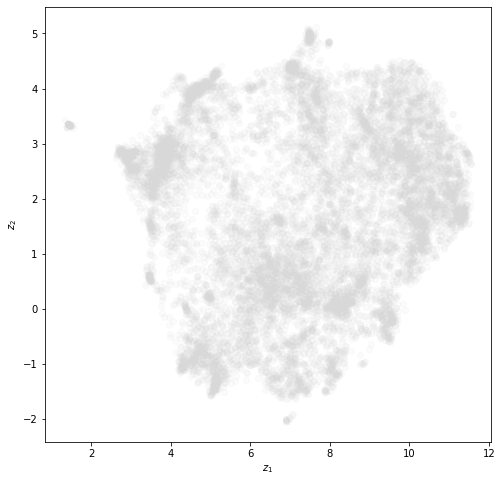

In [99]:
plt.figure(figsize=(8, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.1, color="#d8d8d8")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.show()


array([False, False, False, ..., False, False, False])

In [371]:
# GROUP 1
indices_g1 = np.where(embedding[:, 0] < 2.5)[0]

# GROUP 2
indices_x = np.where(np.logical_and(5 < embedding[:, 0], embedding[:, 0] < 6))[0]
indices_y = np.where(np.logical_and(3.5 < embedding[:, 1], embedding[:, 1] < 4))[0]
indices_g2 = np.intersect1d(indices_x, indices_y)

# GROUP 3
indices_x = np.where(np.logical_and(10 < embedding[:, 0], embedding[:, 0] < 11))[0]
indices_y = np.where(np.logical_and(3.5 < embedding[:, 1], embedding[:, 1] < 4))[0]
indices_g3 = np.intersect1d(indices_x, indices_y)

# GROUP 4
indices_x = np.where(np.logical_and(9 < embedding[:, 0], embedding[:, 0] < 10))[0]
indices_y = np.where(np.logical_and(2 < embedding[:, 1], embedding[:, 1] < 2.5))[0]
indices_g4 = np.intersect1d(indices_x, indices_y)

# GROUP 5
indices_x = np.where(np.logical_and(5 < embedding[:, 0], embedding[:, 0] < 6))[0]
indices_y = np.where(np.logical_and(-1.2 < embedding[:, 1], embedding[:, 1] < -0.5))[0]
indices_g5 = np.intersect1d(indices_x, indices_y)

# GROUP 6
indices_x = np.where(np.logical_and(9 < embedding[:, 0], embedding[:, 0] < 11))[0]
indices_y = np.where(np.logical_and(-1.2 < embedding[:, 1], embedding[:, 1] < -0.5))[0]
indices_g6 = np.intersect1d(indices_x, indices_y)


# GROUP 7
indices_x = np.where(np.logical_and(7 < embedding[:, 0], embedding[:, 0] < 8))[0]
indices_y = np.where(np.logical_and(0.5 < embedding[:, 1], embedding[:, 1] < 1))[0]
indices_g7 = np.intersect1d(indices_x, indices_y)

# GROUP 8
indices_x = np.where(np.logical_and(11 < embedding[:, 0], embedding[:, 0] < 12))[0]
indices_y = np.where(np.logical_and(1 < embedding[:, 1], embedding[:, 1] < 1.5))[0]
indices_g8 = np.intersect1d(indices_x, indices_y)


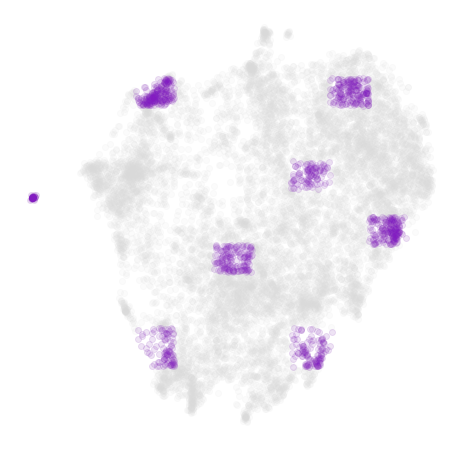

In [372]:
plt.figure(figsize=(8, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.1, color="#d8d8d8")
# GROUP_1
plt.scatter(embedding[indices_g1, 0], embedding[indices_g1, 1], alpha=0.1, color="#8015bf")
# GROUP_2
plt.scatter(embedding[indices_g2, 0], embedding[indices_g2, 1], alpha=0.1, color="#8015bf")
# GROUP_3
plt.scatter(embedding[indices_g3, 0], embedding[indices_g3, 1], alpha=0.1, color="#8015bf")
# GROUP_4
plt.scatter(embedding[indices_g4, 0], embedding[indices_g4, 1], alpha=0.1, color="#8015bf")
# GROUP_5
plt.scatter(embedding[indices_g5, 0], embedding[indices_g5, 1], alpha=0.1, color="#8015bf")

# GROUP_6
plt.scatter(embedding[indices_g6, 0], embedding[indices_g6, 1], alpha=0.1, color="#8015bf")

# GROUP_7
plt.scatter(embedding[indices_g7, 0], embedding[indices_g7, 1], alpha=0.1, color="#8015bf")
# GROUP_8
plt.scatter(embedding[indices_g8, 0], embedding[indices_g8, 1], alpha=0.1, color="#8015bf")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.axis("off")
plt.show()

In [373]:
np.random.shuffle(indices_g8)

In [374]:
imgs = []
IMG_DIR = "/home/simon/Documents/Programming/Data/iec_1024/train_data"
for fname in files[indices_g8]:
    
    if "_lr" in fname:
        continue
    fname = os.path.join(IMG_DIR, fname.split(".")[0] + ".jpg")
    
    img = io.imread(fname)
    img = resize(img, (256, 256))
    
    imgs.append(img)

In [375]:
all_imgs = imgs[0:9]

In [376]:
n = 0
rows = []
for i in range(3):
    row = []
    for j in range(3):
    
        img = all_imgs[n]
        row.append(img)
        n += 1
        
    rows.append(np.hstack(row))

In [377]:
canvas = np.vstack(rows)

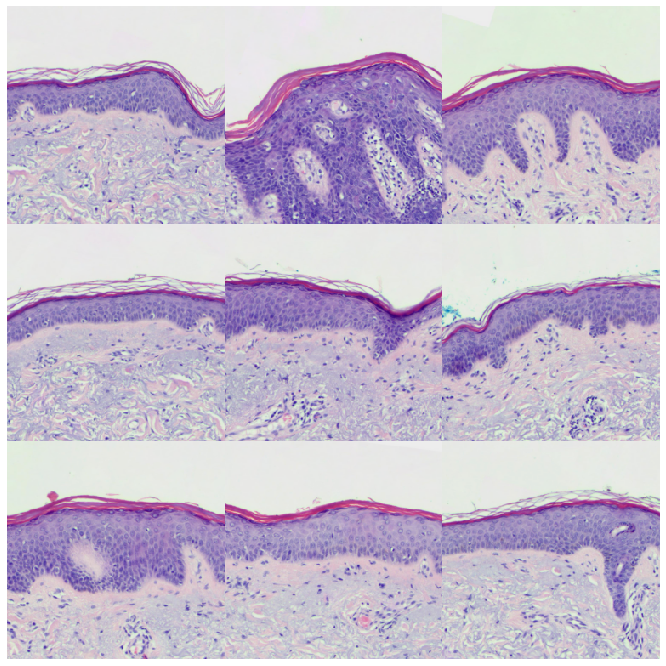

In [378]:
plt.figure(figsize=(12, 12))
plt.imshow(canvas)
plt.axis("off")
plt.show()

# Labels

In [19]:
import pandas as pd

In [20]:
df = pd.read_csv("/home/simon/Documents/Programming/Project3/VQGAN_Annotations/annotation_table_clean.csv")

In [21]:
df

file  index  basket  parakeratosis  thick  thin  distinct  \
0     19H25030_3A_SEBK_2      5       1              0      0     0         1   
1     19H25030_3A_SEBK_2      6       1              0      0     0         1   
2     19H25030_3A_SEBK_2      7       1              0      0     0         1   
3     19H25030_3A_SEBK_2      8       1              0      0     0         1   
4     19H25030_3A_SEBK_2      9       1              0      0     0         1   
...                  ...    ...     ...            ...    ...   ...       ...   
8477  19H22651_1A_SEBK_1     35       0              1      0     0         0   
8478  19H22651_1A_SEBK_1     44       0              0      0     1         0   
8479  19H22651_1A_SEBK_1     46       0              0      0     1         0   
8480  19H22651_1A_SEBK_1     50       1              0      0     0         0   
8481  19H22651_1A_SEBK_1     51       1              0      0     0         0   

      disrupted  no  detached  ...  epi_norm  epi_mild  epi_moderate  \
0             0   0         0  ...         0         0             0   
1             0   0         0  ...         0         0             0   
2             0   0         0  ...         0         0             0   
3             0   0         0  ...         0         0             0   
4             0   0         0  ...         0         0             0   
...         ...  ..       ...  ...       ...       ...           ...   
8477          0   1         0  ...         0         0             0   
8478          0   1         1  ...         0         0             0   
8479          0   1         1  ...         0         0             0   
8480          0   1         1  ...         0         0             0   
8481          0   1         1  ...         0         0             0   

      epi_severe  epi_full  der_norm  der_abnorm  der_solar  der_inf  \
0              1         0         0           0          1        0   
1              1         0         0           0          1        0   
2              1         0         0           0          1        0   
3              1         0         0           0          1        0   
4              1         0         0           0          0        0   
...          ...       ...       ...         ...        ...      ...   
8477           0         1         0           0          0        0   
8478           0         1         0           0          0        0   
8479           0         1         0           0          0        0   
8480           0         1         0           0          0        0   
8481           0         1         0           0          0        0   

      der_displaced  
0                 0  
1                 0  
2                 0  
3                 0  
4                 1  
...             ...  
8477              1  
8478              1  
8479              1  
8480              1  
8481              1  

[8482 rows x 22 columns]

In [22]:
def get_indices_for(key, files):
    mask = np.where(df[key] == 1)[0]
    stop = len(mask)
    
    indices = []
    for j,(f,n) in enumerate(zip(df["file"][mask], df["index"][mask])):

        print(j+1, "of", stop, end="\r")


        for i, file in enumerate(files):
            name = file.split(".")[0]
            if "_lr" in name:
                name = name[0:-3]

            # Check if it is in it
            if name == (f + "_" + str(n)):
                indices.append(i)

    indices = np.array(indices)
    
    return indices

In [23]:
df.keys()

Index(['file', 'index', 'basket', 'parakeratosis', 'thick', 'thin', 'distinct',
       'disrupted', 'no', 'detached', 'fragmented', 'eroded', 'epi_norm',
       'epi_mild', 'epi_moderate', 'epi_severe', 'epi_full', 'der_norm',
       'der_abnorm', 'der_solar', 'der_inf', 'der_displaced'],
      dtype='object')

# Ker

In [24]:
thick_indices = get_indices_for("thick", files)

In [25]:
thin_indices = get_indices_for("thin", files)

In [26]:
para_indices = get_indices_for("parakeratosis", files)

In [27]:
basket_indices = get_indices_for("basket", files)

In [28]:
distinct_indices = get_indices_for("distinct", files)

In [29]:
disrupted_indices = get_indices_for("disrupted", files)

In [30]:
no_indices = get_indices_for("no", files)

In [31]:
detached_indices = get_indices_for("detached", files)

thick_indices


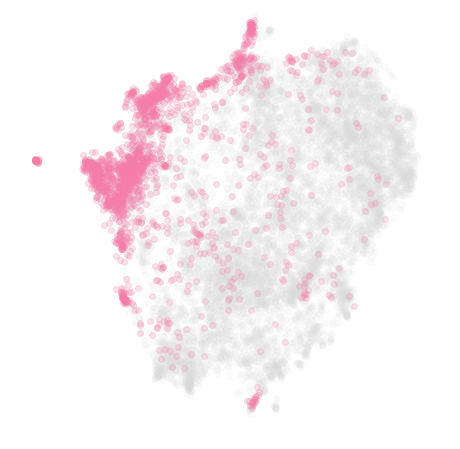

thin_indices


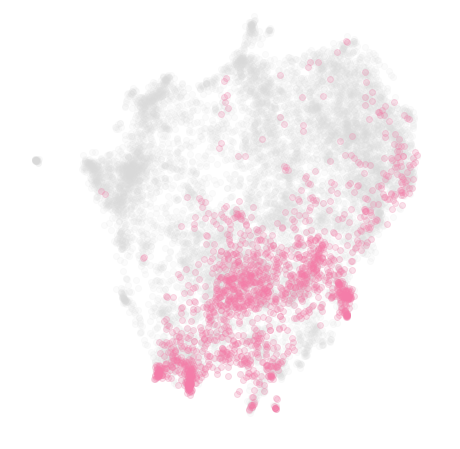

para_indices


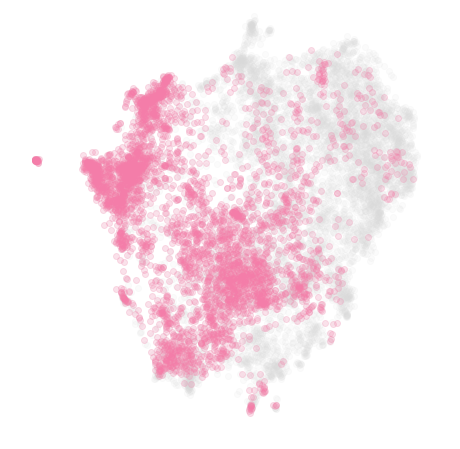

basket_indices


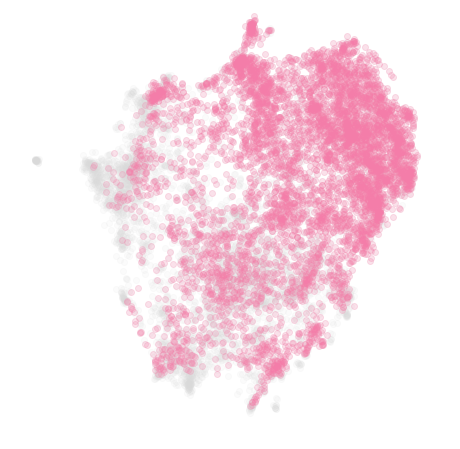

distinct_indices


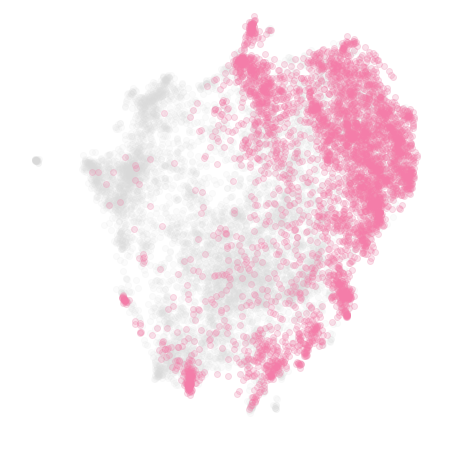

disrupted_indices


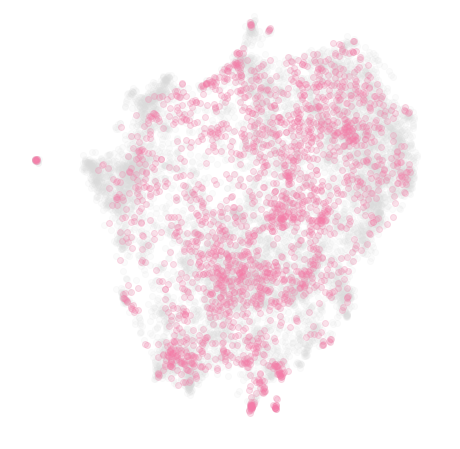

no_indices


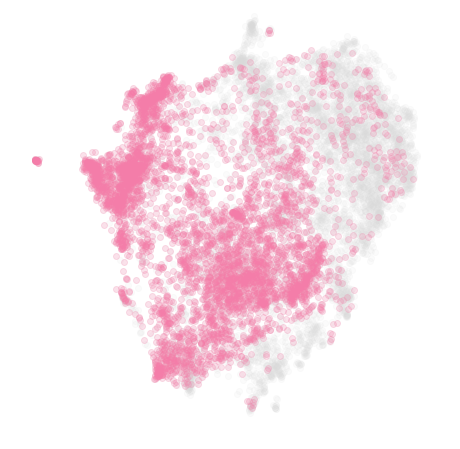

detached_indices


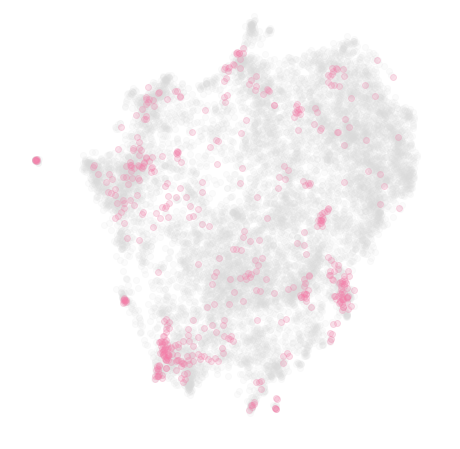

In [57]:
for name in ["thick_indices", "thin_indices", "para_indices", "basket_indices",
             "distinct_indices", "disrupted_indices", "no_indices", "detached_indices",
               ]:
    
    indices = eval(name)
    
    plt.figure(figsize=(8, 8))
    print(name)
    #plt.title(name)
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.1, color="#d8d8d8")
    plt.scatter(embedding[indices, 0], embedding[indices, 1], alpha=0.2, color="#f87ba8")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.axis("off")
    
    plt.xlim(1, 13)
    plt.ylim(-3, 5)
    
    plt.savefig(f"/home/simon/Desktop/Project3/Figures/latent_space_{name}.png", dpi=100)
    
    plt.show()

# Visualise

In [58]:
x1_min = embedding[:, 0].min()
x1_max = embedding[:, 0].max()

In [59]:
x1_min

1.7421825

In [60]:
x2_min = embedding[:, 1].min()
x2_max = embedding[:, 1].max()

In [61]:
embedding[:, 0] = (embedding[:, 0] + abs(x1_min)) 
embedding[:, 1] = (embedding[:, 1] - x2_min)

In [62]:
embedding[:, 0] /= embedding[:, 0].max()
embedding[:, 1] /= embedding[:, 1].max()

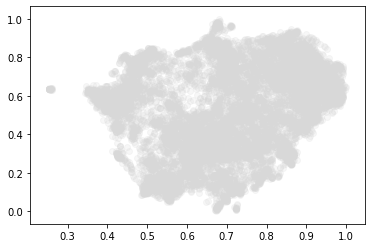

In [63]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2, color="#d8d8d8")
plt.show()

In [64]:
embedding.shape

(11588, 2)

In [65]:
sample_indices = np.arange(0, 10260)
np.random.shuffle(sample_indices)
sample_indices = sample_indices[0:1600]

In [66]:
#embedding[sample_indices, 0]

In [67]:
#embedding[sample_indices, 1]

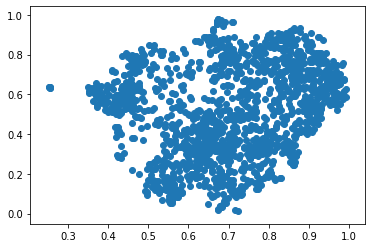

In [68]:
plt.scatter(embedding[sample_indices, 0], embedding[sample_indices, 1])
plt.show()

In [69]:
from scipy.spatial.distance import cdist
from lapjv import lapjv

In [70]:
def save_2d_projection_grid(img_collection, X_2d, out_res, out_dim):
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, out_dim), np.linspace(0, 1, out_dim))).reshape(-1, 2)
    cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
    cost_matrix = cost_matrix * (100000 / cost_matrix.max())

    print(cost_matrix.shape)
    row_asses, col_asses, _ = lapjv(cost_matrix)
    grid_jv = grid[col_asses]
    out = np.ones((out_dim * out_res, out_dim * out_res, 3))

    for pos, img in zip(grid_jv, img_collection[0:np.square(out_dim)]):
        h_range = int(np.floor(pos[0] * (out_dim - 1) * out_res))
        w_range = int(np.floor(pos[1] * (out_dim - 1) * out_res))
        out[h_range:h_range + out_res, w_range:w_range + out_res] = img

    return out

In [32]:
import skimage.io as io
from skimage.transform import resize

In [72]:
img_collection = []
for i, file in enumerate(files[sample_indices]):
    print(i, "of", 1600)
    fname = file.split(".npy")[0]
    
    img = io.imread(os.path.join("/home/simon/Documents/Programming/Data/iec_1024/train_data", fname + ".jpg"))
    
    img = resize(img, (256, 256))
    
    img_collection.append(img)
    
    

0 of 1600
1 of 1600
2 of 1600
3 of 1600
4 of 1600
5 of 1600
6 of 1600
7 of 1600
8 of 1600
9 of 1600
10 of 1600
11 of 1600
12 of 1600
13 of 1600
14 of 1600
15 of 1600
16 of 1600
17 of 1600
18 of 1600
19 of 1600
20 of 1600
21 of 1600
22 of 1600
23 of 1600
24 of 1600
25 of 1600
26 of 1600
27 of 1600
28 of 1600
29 of 1600
30 of 1600
31 of 1600
32 of 1600
33 of 1600
34 of 1600
35 of 1600
36 of 1600
37 of 1600
38 of 1600
39 of 1600
40 of 1600
41 of 1600
42 of 1600
43 of 1600
44 of 1600
45 of 1600
46 of 1600
47 of 1600
48 of 1600
49 of 1600
50 of 1600
51 of 1600
52 of 1600
53 of 1600
54 of 1600
55 of 1600
56 of 1600
57 of 1600
58 of 1600
59 of 1600
60 of 1600
61 of 1600
62 of 1600
63 of 1600
64 of 1600
65 of 1600
66 of 1600
67 of 1600
68 of 1600
69 of 1600
70 of 1600
71 of 1600
72 of 1600
73 of 1600
74 of 1600
75 of 1600
76 of 1600
77 of 1600
78 of 1600
79 of 1600
80 of 1600
81 of 1600
82 of 1600
83 of 1600
84 of 1600
85 of 1600
86 of 1600
87 of 1600
88 of 1600
89 of 1600
90 of 1600
91 of 160

693 of 1600
694 of 1600
695 of 1600
696 of 1600
697 of 1600
698 of 1600
699 of 1600
700 of 1600
701 of 1600
702 of 1600
703 of 1600
704 of 1600
705 of 1600
706 of 1600
707 of 1600
708 of 1600
709 of 1600
710 of 1600
711 of 1600
712 of 1600
713 of 1600
714 of 1600
715 of 1600
716 of 1600
717 of 1600
718 of 1600
719 of 1600
720 of 1600
721 of 1600
722 of 1600
723 of 1600
724 of 1600
725 of 1600
726 of 1600
727 of 1600
728 of 1600
729 of 1600
730 of 1600
731 of 1600
732 of 1600
733 of 1600
734 of 1600
735 of 1600
736 of 1600
737 of 1600
738 of 1600
739 of 1600
740 of 1600
741 of 1600
742 of 1600
743 of 1600
744 of 1600
745 of 1600
746 of 1600
747 of 1600
748 of 1600
749 of 1600
750 of 1600
751 of 1600
752 of 1600
753 of 1600
754 of 1600
755 of 1600
756 of 1600
757 of 1600
758 of 1600
759 of 1600
760 of 1600
761 of 1600
762 of 1600
763 of 1600
764 of 1600
765 of 1600
766 of 1600
767 of 1600
768 of 1600
769 of 1600
770 of 1600
771 of 1600
772 of 1600
773 of 1600
774 of 1600
775 of 1600
776 

1350 of 1600
1351 of 1600
1352 of 1600
1353 of 1600
1354 of 1600
1355 of 1600
1356 of 1600
1357 of 1600
1358 of 1600
1359 of 1600
1360 of 1600
1361 of 1600
1362 of 1600
1363 of 1600
1364 of 1600
1365 of 1600
1366 of 1600
1367 of 1600
1368 of 1600
1369 of 1600
1370 of 1600
1371 of 1600
1372 of 1600
1373 of 1600
1374 of 1600
1375 of 1600
1376 of 1600
1377 of 1600
1378 of 1600
1379 of 1600
1380 of 1600
1381 of 1600
1382 of 1600
1383 of 1600
1384 of 1600
1385 of 1600
1386 of 1600
1387 of 1600
1388 of 1600
1389 of 1600
1390 of 1600
1391 of 1600
1392 of 1600
1393 of 1600
1394 of 1600
1395 of 1600
1396 of 1600
1397 of 1600
1398 of 1600
1399 of 1600
1400 of 1600
1401 of 1600
1402 of 1600
1403 of 1600
1404 of 1600
1405 of 1600
1406 of 1600
1407 of 1600
1408 of 1600
1409 of 1600
1410 of 1600
1411 of 1600
1412 of 1600
1413 of 1600
1414 of 1600
1415 of 1600
1416 of 1600
1417 of 1600
1418 of 1600
1419 of 1600
1420 of 1600
1421 of 1600
1422 of 1600
1423 of 1600
1424 of 1600
1425 of 1600
1426 of 1600

In [73]:
X_2d = embedding[sample_indices][0:int(14*14)]
out_res = 256
out_dim = 14

In [74]:
canvas = save_2d_projection_grid(img_collection[0:1600], X_2d, out_res, out_dim)

(196, 196)


In [75]:
canvas.shape

(3584, 3584, 3)

In [76]:
io.imsave("./2d_proj.jpg", canvas)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


# Epi

In [33]:
epi_norm_indices = get_indices_for("epi_norm", files)

In [34]:
mild_indices = get_indices_for("epi_mild", files)

In [35]:
moderate_indices = get_indices_for("epi_moderate", files)

In [36]:
severe_indices = get_indices_for("epi_severe", files)

In [37]:
full_indices = get_indices_for("epi_full", files)

epi_norm_indices


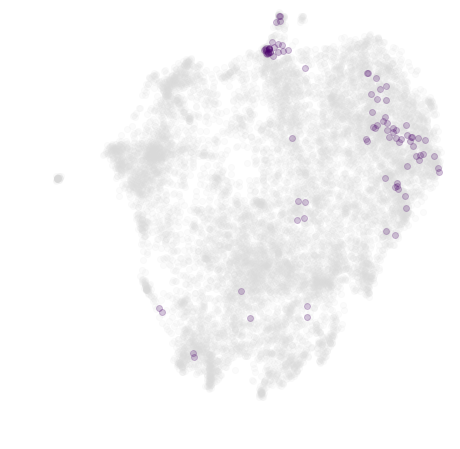

mild_indices


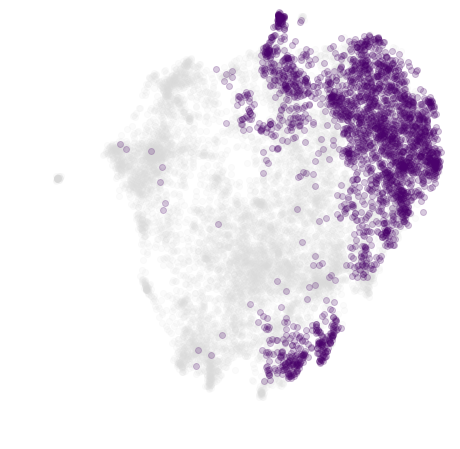

moderate_indices


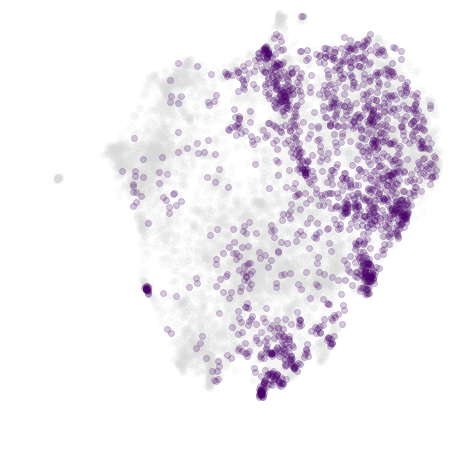

severe_indices


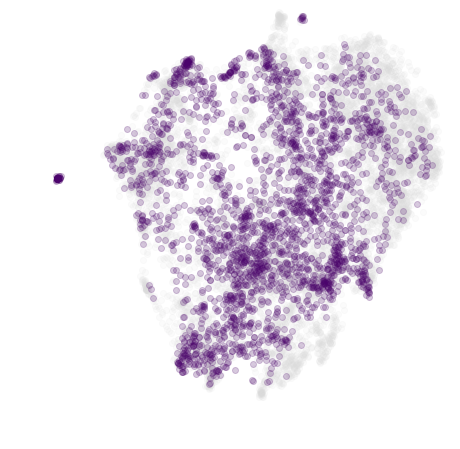

full_indices


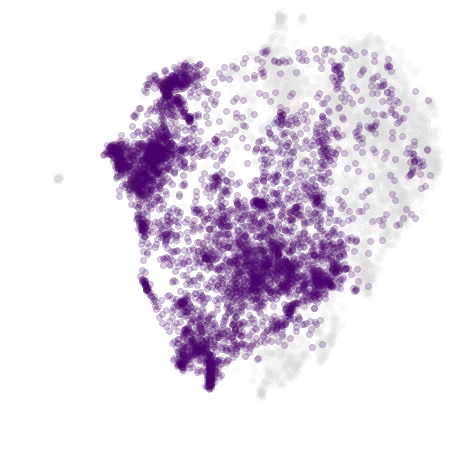

In [98]:
for name in ["epi_norm_indices", "mild_indices", "moderate_indices", "severe_indices", "full_indices"]:
    indices = eval(name)
    
    print(name
         )
    plt.figure(figsize=(8, 8))
    #plt.title(name)
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.1, color="#d8d8d8")
    plt.scatter(embedding[indices, 0], embedding[indices, 1], alpha=0.2, color="#49006a")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.axis("off")
    
    plt.xlim(1, 13)
    plt.ylim(-3, 5)
    
    plt.savefig(f"/home/simon/Desktop/Project3/Figures/latent_space_{name}.png", dpi=100)
    
    plt.show()

# Derm

In [99]:
df.keys()

Index(['file', 'index', 'basket', 'parakeratosis', 'thick', 'thin', 'distinct',
       'disrupted', 'no', 'detached', 'fragmented', 'eroded', 'epi_norm',
       'epi_mild', 'epi_moderate', 'epi_severe', 'epi_full', 'der_norm',
       'der_abnorm', 'der_solar', 'der_inf', 'der_displaced'],
      dtype='object')

In [100]:
norm_indices = severe_indices = get_indices_for("der_norm", files)

In [101]:
solar_indices = get_indices_for("der_solar", files)

In [102]:
abnorm_indices = get_indices_for("der_abnorm", files)

In [103]:
inf_indices = get_indices_for("der_inf", files)

In [104]:
dis_indices = get_indices_for("der_displaced", files)

norm_indices


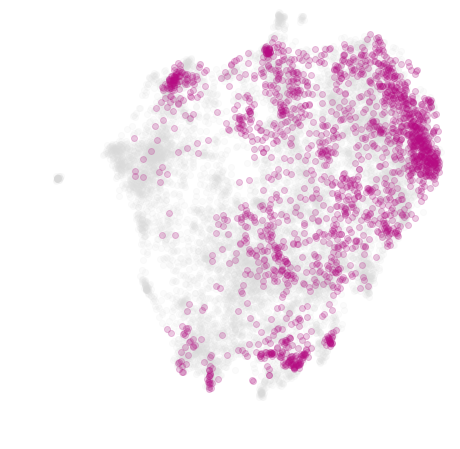

solar_indices


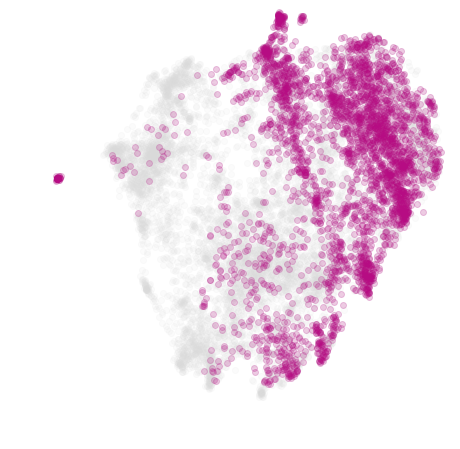

abnorm_indices


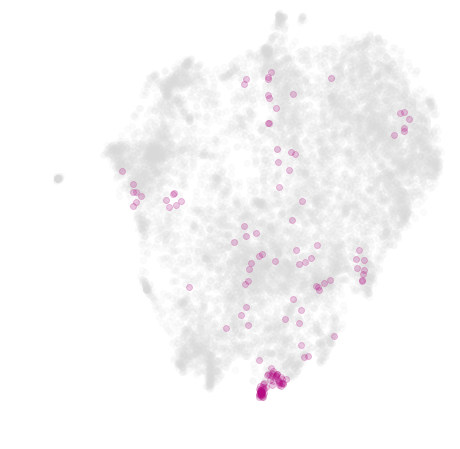

inf_indices


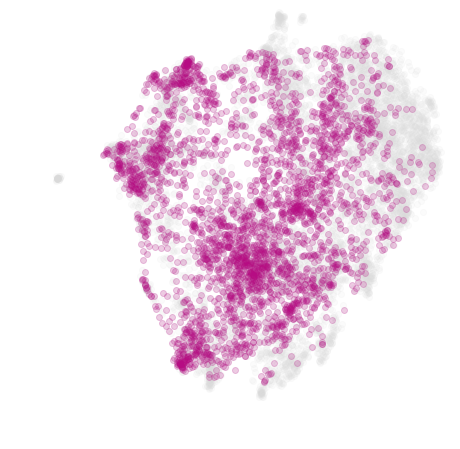

dis_indices


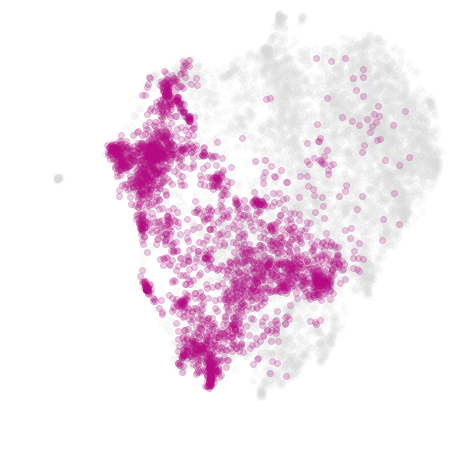

In [105]:
for name in ["norm_indices", "solar_indices", "abnorm_indices", "inf_indices", "dis_indices"]:
    
    indices = eval(name)
    
    print(name)
    
    plt.figure(figsize=(8, 8))
    #plt.title(name)
    plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.1, color="#d8d8d8")
    plt.scatter(embedding[indices, 0], embedding[indices, 1], alpha=0.2, color="#b50982")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.axis("off")
    
    plt.xlim(1, 13)
    plt.ylim(-3, 5)
    
    plt.savefig(f"/home/simon/Desktop/Project3/Figures/latent_space_{name}.png", dpi=100)
    
    plt.show()

In [53]:
concept_indices = {
    "keratin": {
        "thick": None, #thick_indices,
        "thin": None, #thin_indices,
        "parakeratosis": None, #para_indices,
        "basket": None, #basket_indices,
        "distinct": None, #distinct_indices,
        "disrupted": None, #disrupted_indices,
        "none": None, #no_indices,
        "detached": None, #detached_indices
    },

    "derm": {"normal": None, #norm_indices,
             "solar": None, #solar_indices,
             "abnormal": None, #abnorm_indices,
             "inflammation": None, #inf_indices,
             "displaced": None, #dis_indices
            }, 
    
    "epi": {
        "normal" : None, #epi_norm_indices,
        "mild" : None, #mild_indices,
        "moderate" : None, #moderate_indices,
        "severe" : None, #severe_indices,
        "full" : None, #full_indices
    }
}

In [54]:
for key in concept_indices:
    
    for c in concept_indices[key]:
        
        fname = os.path.join("/home/simon/Desktop/Project3/representations/concept_indices", f"{key}_{c}.npy")
        
        #np.save(fname, indices[key][c])
        
        concept_indices[key][c] = np.load(fname)

In [90]:
embedding = reducer.transform(latents)

# Create Validation and Test Latents

In [40]:
TRAIN_DIR = "/home/simon/Desktop/Project3/representations/train_features"
VAL_DIR = "/home/simon/Desktop/Project3/representations/validation_features"
TEST_DIR = "/home/simon/Desktop/Project3/representations/test_features"

In [41]:
TRAIN_FILES = np.array(os.listdir(TRAIN_DIR))
VAL_FILES = np.array(os.listdir(VAL_DIR))
TEST_FILES = np.array(os.listdir(TEST_DIR))

In [42]:
indices = {}
for i, key in enumerate(['basket', 'parakeratosis', 'thin', 'thick', 'epi_mild', 'epi_full',
                         'der_norm', 'der_solar', 'der_inf' ]):
    
    print(i, "of", 20, key)
    print()
    
    print("train...")
    indices[key] = { "train": get_indices_for(key, TRAIN_FILES)}
    print("validation...", end="\n\n")
    indices[key]["val"] = get_indices_for(key, VAL_FILES)
    print("test...", end="\n\n")
    indices[key]["test"] = get_indices_for(key, TEST_FILES)

    print()
    

0 of 20 basket

train...
validation...

test... 45944594 4594 4594 45944594 4594 4594 4594 of 45944594of 45944594 45944594

4594 of 4594of 4594 of 45944594 of 4594 45944594 4594 of 45944594 of 4594
1 of 20 parakeratosis

train...
validation...

test... 3060of 3060306030603060 3060of 3060 30603060 3060 of 3060 of 3060 3060

3060 of 3060of 3060 of 3060 of 30603060 of 3060 of 3060
2 of 20 thin

train...
validation...

test... 12251225 of 1225 of 1225 1225of 1225

1225 of 12251225 12251225 of 1225
3 of 20 thick

train...
validation...

test... 1461461 of 14611461 1461

1461 of 1461f 1461 1461 1461
4 of 20 epi_mild

train...
validation...

test... 208208220822082

2082 of 208282208220822082 2082 20822082 of 2082
5 of 20 epi_full

train...
validation...

test... 3356of 3356 of 3356 of 33563356of 33563356 of 33563356of 3356 of 3356

3356 of 3356356 3356of 3356335633563356 of 33563356 3356
6 of 20 der_norm

train...
validation...

test... 1323323 1323

1323 of 1323of 1323
7 of 20 der_solar

tr

In [43]:
train_indices = np.array(list(range(len(TRAIN_FILES))))
val_indices = np.array(list(range(len(VAL_FILES))))
test_indices = np.array(list(range(len(TEST_FILES))))

# Concept Vectors

In [44]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from matplotlib import cm

In [45]:
concept_vectors = {}

# Basket v Para

In [46]:
# TRAIN ----------------------------------------

print("Train")

pos_i = indices['basket']["train"]
neg_i = indices['parakeratosis']["train"]

train_pos = []
train_neg = []

for f in TRAIN_FILES[pos_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_pos.append(w)

for f in TRAIN_FILES[neg_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_neg.append(w)
    
train_pos = np.vstack(train_pos)
train_neg = np.vstack(train_neg)

# Create labels
X = np.vstack([train_pos, train_neg])
y = np.concatenate([ np.ones(len(train_pos)),
                     np.zeros(len(train_neg))])


# Train model
model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=2000)
#model = LogisticRegression(random_state=0)
clf = model.fit(X, y)

y_pred = clf.predict(X)
y_true = y

# Scoring training data
train_acc = metrics.accuracy_score(y_true, y_pred)
train_sens = metrics.recall_score(y_true, y_pred)
train_spec = metrics.recall_score(1 - y_true, 1 - y_pred)



# ----------- VALIDATION

print("Validation")

pos_i = indices['basket']["val"]
neg_i = indices['parakeratosis']["val"]

val_pos = []
val_neg = []

for f in VAL_FILES[pos_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_pos.append(w)

for f in VAL_FILES[neg_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_neg.append(w)
    
val_pos = np.vstack(val_pos)
val_neg = np.vstack(val_neg)

# Create labels
X = np.vstack([val_pos, val_neg])
y = np.concatenate([ np.ones(len(val_pos)),
                     np.zeros(len(val_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
val_acc = metrics.accuracy_score(y_true, y_pred)
val_sens = metrics.recall_score(y_true, y_pred)
val_spec = metrics.recall_score(1 - y_true, 1 - y_pred)

# ----------- Test

print("Test")

pos_i = indices['basket']["test"]
neg_i = indices['parakeratosis']["test"]

test_pos = []
test_neg = []

for f in TEST_FILES[pos_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_pos.append(w)

for f in TEST_FILES[neg_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_neg.append(w)
    
test_pos = np.vstack(test_pos)
test_neg = np.vstack(test_neg)

# Create labels
X = np.vstack([test_pos, test_neg])
y = np.concatenate([ np.ones(len(test_pos)),
                     np.zeros(len(test_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
test_acc = metrics.accuracy_score(y_true, y_pred)
test_sens = metrics.recall_score(y_true, y_pred)
test_spec = metrics.recall_score(1 - y_true, 1 - y_pred)

line = f"""


Set \t Pos n \t Neg  n \t Acc \t Sensitivity \t Specificity
'Train:' {train_pos.shape[0]} \t {train_neg.shape[0]}\t {train_acc:.4f}\t {train_sens:.4f}\t {train_spec:.4f}
'Val:'   {val_pos.shape[0]} \t {val_neg.shape[0]}\t {val_acc:.4f}\t {val_sens:.4f}\t {val_spec:.4f}
'Test:'  {test_pos.shape[0]} \t {test_neg.shape[0]}\t {test_acc:.4f}\t {test_sens:.4f}\t {test_spec:.4f}

"""

print(line)


concept_vectors["basket_para"] = {
        "scale": np.sqrt(np.sum(clf.coef_[0]**2)),
        "m" : np.copy(clf.coef_[0]),
        "b" : np.copy(clf.intercept_[0])
}

Train
Validation
Test



Set 	 Pos n 	 Neg  n 	 Acc 	 Sensitivity 	 Specificity
'Train:' 6230 	 4244	 0.8513	 0.8777	 0.8124
'Val:'   1452 	 990	 0.8448	 0.8533	 0.8323
'Test:'  1506 	 886	 0.8106	 0.8386	 0.7630




# Thin v Thick

In [47]:
# TRAIN ----------------------------------------

print("Train")

pos_i = indices['thin']["train"]
neg_i = indices['thick']["train"]

train_pos = []
train_neg = []

for f in TRAIN_FILES[pos_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_pos.append(w)

for f in TRAIN_FILES[neg_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_neg.append(w)
    
train_pos = np.vstack(train_pos)
train_neg = np.vstack(train_neg)

# Create labels
X = np.vstack([train_pos, train_neg])
y = np.concatenate([ np.ones(len(train_pos)),
                     np.zeros(len(train_neg))])


# Train model
model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=2000)
#model = LogisticRegression(random_state=0)
clf = model.fit(X, y)

y_pred = clf.predict(X)
y_true = y

# Scoring training data
train_acc = metrics.accuracy_score(y_true, y_pred)
train_sens = metrics.recall_score(y_true, y_pred)
train_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- VALIDATION

print("Validation")

pos_i = indices['thin']["val"]
neg_i = indices['thick']["val"]

val_pos = []
val_neg = []

for f in VAL_FILES[pos_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_pos.append(w)

for f in VAL_FILES[neg_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_neg.append(w)
    
val_pos = np.vstack(val_pos)
val_neg = np.vstack(val_neg)

# Create labels
X = np.vstack([val_pos, val_neg])
y = np.concatenate([ np.ones(len(val_pos)),
                     np.zeros(len(val_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
val_acc = metrics.accuracy_score(y_true, y_pred)
val_sens = metrics.recall_score(y_true, y_pred)
val_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- Test

print("Test")

pos_i = indices['thin']["test"]
neg_i = indices['thick']["test"]

test_pos = []
test_neg = []

for f in TEST_FILES[pos_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_pos.append(w)

for f in TEST_FILES[neg_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_neg.append(w)
    
test_pos = np.vstack(test_pos)
test_neg = np.vstack(test_neg)

# Create labels
X = np.vstack([test_pos, test_neg])
y = np.concatenate([ np.ones(len(test_pos)),
                     np.zeros(len(test_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
test_acc = metrics.accuracy_score(y_true, y_pred)
test_sens = metrics.recall_score(y_true, y_pred)
test_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


line = f"""


Set \t Pos n \t Neg  n \t Acc \t Sensitivity \t Specificity
'Train:' {train_pos.shape[0]} \t {train_neg.shape[0]}\t {train_acc:.4f}\t {train_sens:.4f}\t {train_spec:.4f}
'Val:'   {val_pos.shape[0]} \t {val_neg.shape[0]}\t {val_acc:.4f}\t {val_sens:.4f}\t {val_spec:.4f}
'Test:'  {test_pos.shape[0]} \t {test_neg.shape[0]}\t {test_acc:.4f}\t {test_sens:.4f}\t {test_spec:.4f}

"""

print(line)


concept_vectors["thin_thick"] = {
        "scale": np.sqrt(np.sum(clf.coef_[0]**2)),
        "m" : np.copy(clf.coef_[0]),
        "b" : np.copy(clf.intercept_[0])
}


Train
Validation
Test



Set 	 Pos n 	 Neg  n 	 Acc 	 Sensitivity 	 Specificity
'Train:' 1684 	 1996	 0.9989	 0.9988	 0.9990
'Val:'   396 	 480	 0.9600	 0.9621	 0.9583
'Test:'  370 	 446	 0.9608	 0.9838	 0.9417




# Mild V Full

In [48]:
# TRAIN ----------------------------------------

print("Train")

pos_i = indices['epi_mild']["train"]
neg_i = indices['epi_full']["train"]

train_pos = []
train_neg = []

for f in TRAIN_FILES[pos_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_pos.append(w)

for f in TRAIN_FILES[neg_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_neg.append(w)
    
train_pos = np.vstack(train_pos)
train_neg = np.vstack(train_neg)

# Create labels
X = np.vstack([train_pos, train_neg])
y = np.concatenate([ np.ones(len(train_pos)),
                     np.zeros(len(train_neg))])


# Train model
model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=2000)
#model = LogisticRegression(random_state=0)
clf = model.fit(X, y)

y_pred = clf.predict(X)
y_true = y

# Scoring training data
train_acc = metrics.accuracy_score(y_true, y_pred)
train_sens = metrics.recall_score(y_true, y_pred)
train_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- VALIDATION

print("Validation")

pos_i = indices['epi_mild']["val"]
neg_i = indices['epi_full']["val"]

val_pos = []
val_neg = []

for f in VAL_FILES[pos_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_pos.append(w)

for f in VAL_FILES[neg_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_neg.append(w)
    
val_pos = np.vstack(val_pos)
val_neg = np.vstack(val_neg)

# Create labels
X = np.vstack([val_pos, val_neg])
y = np.concatenate([ np.ones(len(val_pos)),
                     np.zeros(len(val_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
val_acc = metrics.accuracy_score(y_true, y_pred)
val_sens = metrics.recall_score(y_true, y_pred)
val_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- Test

print("Test")

pos_i = indices['epi_mild']["test"]
neg_i = indices['epi_full']["test"]

test_pos = []
test_neg = []

for f in TEST_FILES[pos_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_pos.append(w)

for f in TEST_FILES[neg_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_neg.append(w)
    
test_pos = np.vstack(test_pos)
test_neg = np.vstack(test_neg)

# Create labels
X = np.vstack([test_pos, test_neg])
y = np.concatenate([ np.ones(len(test_pos)),
                     np.zeros(len(test_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
test_acc = metrics.accuracy_score(y_true, y_pred)
test_sens = metrics.recall_score(y_true, y_pred)
test_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


line = f"""


Set \t Pos n \t Neg  n \t Acc \t Sensitivity \t Specificity
'Train:' {train_pos.shape[0]} \t {train_neg.shape[0]}\t {train_acc:.4f}\t {train_sens:.4f}\t {train_spec:.4f}
'Val:'   {val_pos.shape[0]} \t {val_neg.shape[0]}\t {val_acc:.4f}\t {val_sens:.4f}\t {val_spec:.4f}
'Test:'  {test_pos.shape[0]} \t {test_neg.shape[0]}\t {test_acc:.4f}\t {test_sens:.4f}\t {test_spec:.4f}

"""

print(line)


concept_vectors["mild_full"] = {
        "scale": np.sqrt(np.sum(clf.coef_[0]**2)),
        "m" : np.copy(clf.coef_[0]),
        "b" : np.copy(clf.intercept_[0])
}


Train
Validation
Test



Set 	 Pos n 	 Neg  n 	 Acc 	 Sensitivity 	 Specificity
'Train:' 2704 	 4536	 1.0000	 1.0000	 1.0000
'Val:'   868 	 1146	 0.9230	 0.8917	 0.9468
'Test:'  592 	 1030	 0.9322	 0.9071	 0.9466




# Normal  V Solar

In [49]:
# TRAIN ----------------------------------------

print("Train")

pos_i = indices['der_norm']["train"]
neg_i = indices['der_solar']["train"]

train_pos = []
train_neg = []

for f in TRAIN_FILES[pos_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_pos.append(w)

for f in TRAIN_FILES[neg_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_neg.append(w)
    
train_pos = np.vstack(train_pos)
train_neg = np.vstack(train_neg)

# Create labels
X = np.vstack([train_pos, train_neg])
y = np.concatenate([ np.ones(len(train_pos)),
                     np.zeros(len(train_neg))])


# Train model
model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=2000)
#model = LogisticRegression(random_state=0)
clf = model.fit(X, y)

y_pred = clf.predict(X)
y_true = y

# Scoring training data
train_acc = metrics.accuracy_score(y_true, y_pred)
train_sens = metrics.recall_score(y_true, y_pred)
train_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- VALIDATION

print("Validation")

pos_i = indices['der_norm']["val"]
neg_i = indices['der_solar']["val"]

val_pos = []
val_neg = []

for f in VAL_FILES[pos_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_pos.append(w)

for f in VAL_FILES[neg_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_neg.append(w)
    
val_pos = np.vstack(val_pos)
val_neg = np.vstack(val_neg)

# Create labels
X = np.vstack([val_pos, val_neg])
y = np.concatenate([ np.ones(len(val_pos)),
                     np.zeros(len(val_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
val_acc = metrics.accuracy_score(y_true, y_pred)
val_sens = metrics.recall_score(y_true, y_pred)
val_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- Test

print("Test")

pos_i = indices['der_norm']["test"]
neg_i = indices['der_solar']["test"]

test_pos = []
test_neg = []

for f in TEST_FILES[pos_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_pos.append(w)

for f in TEST_FILES[neg_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_neg.append(w)
    
test_pos = np.vstack(test_pos)
test_neg = np.vstack(test_neg)

# Create labels
X = np.vstack([test_pos, test_neg])
y = np.concatenate([ np.ones(len(test_pos)),
                     np.zeros(len(test_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
test_acc = metrics.accuracy_score(y_true, y_pred)
test_sens = metrics.recall_score(y_true, y_pred)
test_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


line = f"""


Set \t Pos n \t Neg  n \t Acc \t Sensitivity \t Specificity
'Train:' {train_pos.shape[0]} \t {train_neg.shape[0]}\t {train_acc:.4f}\t {train_sens:.4f}\t {train_spec:.4f}
'Val:'   {val_pos.shape[0]} \t {val_neg.shape[0]}\t {val_acc:.4f}\t {val_sens:.4f}\t {val_spec:.4f}
'Test:'  {test_pos.shape[0]} \t {test_neg.shape[0]}\t {test_acc:.4f}\t {test_sens:.4f}\t {test_spec:.4f}

"""

print(line)


concept_vectors["norm_solar"] = {
        "scale": np.sqrt(np.sum(clf.coef_[0]**2)),
        "m" : np.copy(clf.coef_[0]),
        "b" : np.copy(clf.intercept_[0])
}


Train
Validation
Test



Set 	 Pos n 	 Neg  n 	 Acc 	 Sensitivity 	 Specificity
'Train:' 1932 	 3544	 0.8486	 0.7629	 0.8953
'Val:'   374 	 1102	 0.8388	 0.6310	 0.9093
'Test:'  340 	 904	 0.8223	 0.7059	 0.8662




# Norm V Inflammation

In [50]:
# TRAIN ----------------------------------------

print("Train")

pos_i = indices['der_norm']["train"]
neg_i = indices['der_inf']["train"]

train_pos = []
train_neg = []

for f in TRAIN_FILES[pos_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_pos.append(w)

for f in TRAIN_FILES[neg_i]:

    fname = os.path.join(TRAIN_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    train_neg.append(w)
    
train_pos = np.vstack(train_pos)
train_neg = np.vstack(train_neg)

# Create labels
X = np.vstack([train_pos, train_neg])
y = np.concatenate([ np.ones(len(train_pos)),
                     np.zeros(len(train_neg))])


# Train model
model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=2000)
#model = LogisticRegression(random_state=0)
clf = model.fit(X, y)

y_pred = clf.predict(X)
y_true = y

# Scoring training data
train_acc = metrics.accuracy_score(y_true, y_pred)
train_sens = metrics.recall_score(y_true, y_pred)
train_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- VALIDATION

print("Validation")

pos_i = indices['der_norm']["val"]
neg_i = indices['der_inf']["val"]

val_pos = []
val_neg = []

for f in VAL_FILES[pos_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_pos.append(w)

for f in VAL_FILES[neg_i]:

    fname = os.path.join(VAL_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    val_neg.append(w)
    
val_pos = np.vstack(val_pos)
val_neg = np.vstack(val_neg)

# Create labels
X = np.vstack([val_pos, val_neg])
y = np.concatenate([ np.ones(len(val_pos)),
                     np.zeros(len(val_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
val_acc = metrics.accuracy_score(y_true, y_pred)
val_sens = metrics.recall_score(y_true, y_pred)
val_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


# ----------- Test

print("Test")

pos_i = indices['der_norm']["test"]
neg_i = indices['der_inf']["test"]

test_pos = []
test_neg = []

for f in TEST_FILES[pos_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_pos.append(w)

for f in TEST_FILES[neg_i]:

    fname = os.path.join(TEST_DIR, f)

    feat = np.load(fname)

    w = encoder(feat).numpy()

    test_neg.append(w)
    
test_pos = np.vstack(test_pos)
test_neg = np.vstack(test_neg)

# Create labels
X = np.vstack([test_pos, test_neg])
y = np.concatenate([ np.ones(len(test_pos)),
                     np.zeros(len(test_neg))])


y_pred = clf.predict(X)
y_true = y

# Scoring training data
test_acc = metrics.accuracy_score(y_true, y_pred)
test_sens = metrics.recall_score(y_true, y_pred)
test_spec = metrics.recall_score(1 - y_true, 1 - y_pred)


line = f"""


Set \t Pos n \t Neg  n \t Acc \t Sensitivity \t Specificity
'Train:' {train_pos.shape[0]} \t {train_neg.shape[0]}\t {train_acc:.4f}\t {train_sens:.4f}\t {train_spec:.4f}
'Val:'   {val_pos.shape[0]} \t {val_neg.shape[0]}\t {val_acc:.4f}\t {val_sens:.4f}\t {val_spec:.4f}
'Test:'  {test_pos.shape[0]} \t {test_neg.shape[0]}\t {test_acc:.4f}\t {test_sens:.4f}\t {test_spec:.4f}

"""

print(line)


concept_vectors["norm_inf"] = {
        "scale": np.sqrt(np.sum(clf.coef_[0]**2)),
        "m" : np.copy(clf.coef_[0]),
        "b" : np.copy(clf.intercept_[0])
}


Train
Validation
Test



Set 	 Pos n 	 Neg  n 	 Acc 	 Sensitivity 	 Specificity
'Train:' 1932 	 3176	 0.8955	 0.8540	 0.9207
'Val:'   374 	 608	 0.8065	 0.6364	 0.9112
'Test:'  340 	 718	 0.8270	 0.6471	 0.9123




In [51]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [35]:
color_map = cm.magma

In [36]:
for concept in concept_vectors:
    
    C = concept_vectors[concept]["m"]  / concept_vectors[concept]["scale"] 

    scores = np.dot(C, latents.T) + concept_vectors[concept]["b"]  / concept_vectors[concept]["scale"] 
    scores = np.copy(scores)
    
    MIN = abs(scores.min())
    scores += MIN
    MAX = scores.max()
    scores /= MAX
        
    colors = color_map(scores)

    plt.figure(figsize=(8, 8))
    #plt.title(concept)
    print(concept)
    a = plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.4, c=colors)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.axis("off")
    plt.show()
    

basket_para


NameError: name 'embedding' is not defined

<Figure size 576x576 with 0 Axes>

# Vector Arithmetic 

### Thin Thick

In [59]:
np.random.shuffle(thin_indices)

In [60]:
# Thin
w_thin = []
for file in files[thin_indices][0:5]:
    
    fname = os.path.join(TRAIN_DIR, file)
    
    feat = np.load(fname)
    
    
    w = encoder(feat).numpy()
    
    w_thin.append(w)

In [62]:
feats = []
concept = 'thin_thick'
C = concept_vectors[concept]["m"] # / concept_vectors[concept]["scale"] 
b = concept_vectors[concept]["b"] # / concept_vectors[concept]["scale"]

for w in w_thin:
    
    interps = []
    for f in np.arange(-5, 6, 0.1):

        inter_w = f*C + w
        
        
        feat_pred = decoder(inter_w).numpy()
        
        interps.append(feat_pred)
    
    feats.append(np.vstack(interps))
        

In [63]:
data = np.stack(feats)

In [64]:
np.save("./thin_thick_interp.npy", data)

In [65]:
data.shape

(5, 110, 16, 16, 256)

# Basket Weave 

In [67]:
np.random.shuffle(basket_indices)

In [68]:
# Thin
ws = []
for file in files[basket_indices][0:5]:
    
    fname = os.path.join(TRAIN_DIR, file)
    
    feat = np.load(fname)
    
    
    w = encoder(feat).numpy()
    
    ws.append(w)

In [71]:
feats = []
concept = 'basket_para'
C = concept_vectors[concept]["m"] # / concept_vectors[concept]["scale"] 
b = concept_vectors[concept]["b"] # / concept_vectors[concept]["scale"]

for w in ws:
    
    interps = []
    for f in np.arange(-5, 6, 0.1):

        inter_w = f*C + w
        
        
        feat_pred = decoder(inter_w).numpy()
        
        interps.append(feat_pred)
    
    feats.append(np.vstack(interps))

In [72]:
data = np.stack(feats)

In [73]:
np.save("./basket_para_interp.npy", data)

### Dysplasia

In [76]:
np.random.shuffle(mild_indices)

In [77]:
# Thin
ws = []
for file in files[mild_indices][0:5]:
    
    fname = os.path.join(TRAIN_DIR, file)
    
    feat = np.load(fname)
    
    
    w = encoder(feat).numpy()
    
    ws.append(w)

In [78]:
feats = []
concept = 'mild_full'
C = concept_vectors[concept]["m"] 
b = concept_vectors[concept]["b"]

for w in ws:
    
    interps = []
    for f in np.arange(-5, 6, 0.1):

        inter_w = f*C + w
        
        
        feat_pred = decoder(inter_w).numpy()
        
        interps.append(feat_pred)
    
    feats.append(np.vstack(interps))

In [79]:
data = np.stack(feats)

In [81]:
np.save("./mild_full_interp.npy", data)

### Norm Solar

In [85]:
np.random.shuffle(indices["der_norm"]["train"])

In [87]:
# Thin
ws = []
for file in files[indices["der_norm"]["train"]][0:5]:
    
    fname = os.path.join(TRAIN_DIR, file)
    
    feat = np.load(fname)
    
    
    w = encoder(feat).numpy()
    
    ws.append(w)

In [89]:
feats = []
concept = 'norm_solar'
C = concept_vectors[concept]["m"] 
b = concept_vectors[concept]["b"]

for w in ws:
    
    interps = []
    for f in np.arange(-5, 6, 0.1):

        inter_w = f*C + w
        
        
        feat_pred = decoder(inter_w).numpy()
        
        interps.append(feat_pred)
    
    feats.append(np.vstack(interps))
    
data = np.stack(feats)

np.save("./norm_solar_interp.npy", data)

### Norm Inflammation

In [91]:
np.random.shuffle(indices["der_norm"]["train"])

In [92]:
# Thin
ws = []
for file in files[indices["der_norm"]["train"]][0:5]:
    
    fname = os.path.join(TRAIN_DIR, file)
    
    feat = np.load(fname)
    
    
    w = encoder(feat).numpy()
    
    ws.append(w)

In [93]:
feats = []
concept = 'norm_inf'
C = concept_vectors[concept]["m"] 
b = concept_vectors[concept]["b"]

for w in ws:
    
    interps = []
    for f in np.arange(-5, 6, 0.1):

        inter_w = f*C + w
        
        
        feat_pred = decoder(inter_w).numpy()
        
        interps.append(feat_pred)
    
    feats.append(np.vstack(interps))
    
data = np.stack(feats)

np.save("./norm_inf_interp.npy", data)

# Interpolations

In [103]:
sample_indices = np.arange(len(latents))
np.random.shuffle(sample_indices)

In [169]:
interp_latents = latents[sample_indices[0:12]]

In [170]:
i1 = 10
i2 = 11
x1 = interp_latents[i1]
x2 = interp_latents[i2]

feats = []
step = 0.1

inters = []
for a in np.arange(0, 1+step, step):
    
    inter = x1*a + (1-a)*x2
    
    inters.append(inter)
    
    feat = decoder(inter[np.newaxis]).numpy()
    
    feats.append(feat)
    
np.save(f"./interpolation_x{i1}_x{i2}.npy", np.vstack(feats))

In [171]:
ds = []
for w in inters:
    
    d2 = reducer.transform(w.reshape(1, 512))
    
    ds.append(d2)

In [172]:
ds = np.vstack(ds)

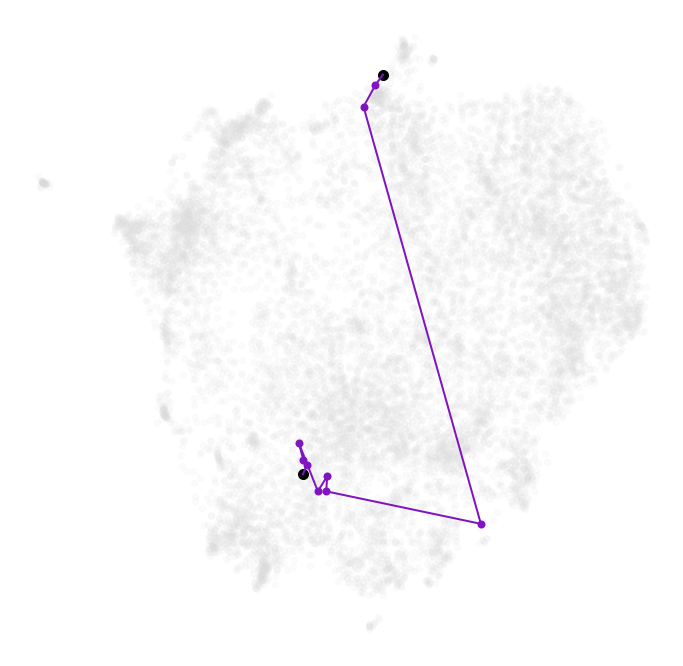

In [173]:
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.1, color="#d8d8d8")
plt.scatter(ds[:, 0], ds[:, 1], alpha=1, color="#8015bf", lw=2)
plt.plot(ds[:, 0], ds[:, 1], alpha=1, color="#8015bf", lw=2)
plt.scatter(ds[0, 0], ds[0, 1], alpha=1, color="black", s=100)
plt.scatter(ds[-1, 0], ds[-1, 1], alpha=1, color="black", s=100)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.axis("off")
plt.show()